# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:49<00:00, 1783.34it/s]


In [23]:
preprocessed_reviews[40000]

'enjoy coffee much easy use pod coffee bold taste'

In [24]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[10]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[15]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[49]
print(sent_4900)
print("="*50)

made in china
I should read those reviews before ordered.
Worthless Indoor Trap
Nylabones Are Great


In [25]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

made in china


In [26]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

made in china
I should read those reviews before ordered.
Worthless Indoor Trap
Nylabones Are Great


In [27]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Worthless Indoor Trap


In [29]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

made in china


In [30]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Worthless Indoor Trap


In [31]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [32]:
# Combining all the above stundents 
from tqdm import tqdm
Summary_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    Summary_reviews.append(sentance.strip())

 37%|███████████████████████████▋                                              | 32798/87773 [00:13<00:31, 1756.16it/s]C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▊                      | 61414/87773 [00:26<00:14, 1811.60it/s]C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 75%|███████████████████████████████████████████████████████▎                  | 65597/87773 [00:28<00:10, 2142.54it/s]C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks 

In [33]:
len(Summary_reviews)

87773

In [34]:
length_of_Summary=[]
for i in range(len(Summary_reviews)):
    length_of_Summary.append(len(Summary_reviews[i]))

In [35]:
print(length_of_Summary[:5])

[10, 17, 18, 24, 7]


In [36]:
final['length_of_Summary']=length_of_Summary

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [37]:
## Similartly you can do preprocessing for review summary also.

In [38]:
final['Summary']

22620                                        made in china
22621                                    Dog Lover Delites
70677                              only one fruitfly stuck
70676              Doesn't work!! Don't waste your money!!
70675                                        A big rip off
70673               THIS ITEM IS EXCELLENT TO KILL INSECTS
70672                                          Didn't work
70671                                  Gross but effective
70670                                  Didn't work for me.
70669                                       Waste of money
70668          I should read those reviews before ordered.
70661                            Doesn't catch fruit flies
70667                              Complete Waste of Money
70666                                               RIpoff
70665                                            It's junk
70662                                Worthless Indoor Trap
70663              Epic Fail - Worst Fly Trap Ever Creat

In [39]:
final.iloc[0]

Id                                                                    24750
ProductId                                                        2734888454
UserId                                                       A13ISQV0U9GZIC
ProfileName                                                       Sandikaye
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    1
Score                                                                     0
Time                                                             1192060800
Summary                                                       made in china
Text                      My dogs loves this chicken but its a product f...
length_of_Summary                                                        10
Name: 22620, dtype: object

In [40]:
from nltk.stem import PorterStemmer

In [41]:
len(preprocessed_reviews)

87773

In [42]:
a=5
for i in range(a):
    print(preprocessed_reviews[i])
    print("***********************")

dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports
***********************
dogs love saw pet store tag attached regarding made china satisfied safe
***********************
infestation fruitflies literally everywhere flying around kitchen bought product hoping least get rid weeks fly stuck going around notepad squishing buggers success rate day clearly product useless even dabbed red wine banana top column week really attracted red wine glass still nothing get stuck actually saw second fly land watched flapped wings frantically within secs unstuck product total waste money
***********************
worst product gotten long time would rate no star could simply not catch single fly bug sort went hardware store bought old fashioned spiral fly paper effective unuasual influx flys house fall needed something
***********************
wish would read reviews making purchase basically c

In [43]:
type(preprocessed_reviews)

list

In [44]:
preprocessed_reviews[4]

'wish would read reviews making purchase basically cardsotck box sticky outside pink ish things look like entrances trap pictures no inside trap flies stuck outside basically fly paper horribly horribly horribly overpriced favor get fly paper fly strips yuck factor much cheaper'

In [45]:
preprocessed_reviews[4]=preprocessed_reviews[4]+' '+Summary_reviews[4]

In [46]:
print(preprocessed_reviews[4])

wish would read reviews making purchase basically cardsotck box sticky outside pink ish things look like entrances trap pictures no inside trap flies stuck outside basically fly paper horribly horribly horribly overpriced favor get fly paper fly strips yuck factor much cheaper big rip


In [47]:
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]=preprocessed_reviews[i]+' '+Summary_reviews[i]

In [48]:
print(preprocessed_reviews[6])

thing item trapped fruit flies not work fly trap would not recommend not work


In [49]:
print(Summary_reviews[6])

not work


In [50]:
%%time
#Reference: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
#Refernce:https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
lemmatizer = WordNetLemmatizer()

def lem_Sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    lem_sentence=[]
    for word in token_words:
        lem_sentence.append(lemmatizer.lemmatize(word))
        lem_sentence.append(" ")
    return "".join(lem_sentence)
for i in range(len(preprocessed_reviews)):
     preprocessed_reviews[i]=lem_Sentence(preprocessed_reviews[i])
     print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335


6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973


8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611


10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
1020

11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
1157

12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
1293

14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
1435

16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
1619

17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
1777418287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365

20153
20154
20155
20156
20157
20158
20159
20160
20161
20162
20163
20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174
20175
20176
20177
20178
20179
20180
20181
20182
20183
20184
20185
20186
20187
20188
20189
20190
20191
20192
20193
20194
20195
20196
20197
20198
20199
20200
20201
20202
20203
20204
20205
20206
20207
20208
20209
20210
20211
20212
20213
20214
20215
20216
20217
20218
20219
20220
20221
20222
20223
20224
20225
20226
20227
20228
20229
20230
20231
20232
20233
20234
20235
20236
20237
20238
20239
20240
20241
20242
20243
20244
20245
20246
20247
20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20280
20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
20291
20292
20293
20294
20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305
20306
20307
20308
20309
20310
20311
20312
20313
20314
20315
20316
20317
20318
2031

21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970
21971
21972
21973
21974
21975
21976
21977
21978
21979
21980
21981
21982
21983
21984
21985
21986
21987
21988
21989
21990
21991
21992
21993
21994
21995
21996
21997
21998
21999
22000
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037
22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22058
22059
22060
22061
22062
22063
22064
22065
22066
2206

23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
2393

25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464
25465
25466
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487
25488
25489
25490
25491
25492
25493
25494
25495
25496
25497
25498
25499
25500
25501
25502
25503
25504
25505
25506
25507
25508
25509
25510
25511
25512
25513
25514
25515
25516
25517
25518
25519
25520
25521
25522
25523
25524
25525
25526
25527
25528
25529
25530
25531
25532
25533
25534
25535
25536
25537
25538
25539
25540
25541
25542
25543
25544
25545
25546
25547
25548
25549
25550
25551
25552
25553
25554
25555
25556
25557
25558
25559
25560
25561
25562
25563
25564
25565
25566
25567
25568
25569
25570
25571
25572
25573
25574
25758
25759
25760
25761
25762
25763
25764
25765
25766
25767
25768
25769
25770
25771
25772
25773
25774
25775
25776
25777
25778
25779
25780
25781
25782
25783
25784
25785
25786
25787
25788
25789
25790
25791
25792
25793
25794
25795
2579

27246
27247
27248
27249
27250
27251
27252
27253
27254
27255
27256
27257
27258
27259
27260
27261
27262
27263
27264
27265
27266
27267
27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295
27296
27297
27298
27299
27300
27301
27302
27303
27304
27305
27306
27307
27308
27309
27310
27311
27312
27313
27314
27315
27316
27317
27318
27319
27320
27321
27322
27323
27324
27325
27326
27327
27328
27329
27330
27331
27332
27333
27334
27335
27336
27337
27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
2741

28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677
28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703
28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28986
28987
28988
28989
28990
28991
28992
28993
28994
28995
28996
28997
28998
28999
29000
29001
29002
29003
2900

30501
30502
30503
30504
30505
30506
30507
30508
30509
30510
30511
30512
30513
30514
30515
30516
30517
30518
30519
30520
30521
30522
30523
30524
30525
30526
30527
30528
30529
30530
30531
30532
30533
30534
30535
30536
30537
30538
30539
30540
30541
30542
30543
30544
30545
30546
30547
30548
30549
30550
30551
30552
30553
30554
30555
30556
30557
30558
30559
30560
30561
30562
30563
30564
30565
30566
30567
30568
30569
30570
30571
30572
30573
30574
30575
30576
30577
30578
30579
30580
30581
30582
30583
30584
30585
30586
30587
30588
30589
30590
30591
30592
30593
30594
30595
30596
30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
3066

32341
32342
32343
32344
32345
32346
32347
32348
32349
32350
32351
32352
32353
32354
32355
32356
32357
32358
32359
32360
32361
32362
32363
32364
32365
32366
32367
32368
32369
32370
32371
32372
32373
32374
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386
32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
32425
32426
32427
32428
32429
32430
32431
32432
32433
32434
32435
32436
32437
32438
32439
32440
32441
32442
32443
32444
32445
32446
32447
32448
32449
32450
32451
32452
32453
32454
32455
32456
32457
32458
32459
32460
32461
32462
32463
32464
32465
32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483
32484
32485
32486
32487
32488
32489
32490
32491
32492
32493
32494
32495
32496
32497
32498
32499
32500
32501
32502
32503
32504
32505
32506
3250

34331
34332
34333
34334
34335
34336
34337
34338
34339
34340
34341
34342
34343
34344
34345
34346
34347
34348
34349
34350
34351
34352
34353
34354
34355
34356
34357
34358
34359
34360
34361
34362
34363
34364
34365
34366
34367
34368
34369
34370
34371
34372
34373
34374
34375
34376
34377
34378
34379
34380
34381
34382
34383
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589
34590
34591
34592
34593
34594
34595
34596
34597
34598
34599
34600
34601
34602
34603
34604
34605
34606
34607
34608
34609
34610
34611
34612
34613
34614
34615
34616
34617
34618
34619
34620
34621
34622
34623
34624
34625
34626
34627
34628
34629
34630
34631
34632
34633
34634
34635
34636
34637
34638
34639
34640
34641
34642
34643
34644
34645
34646
34647
34648
34649
34650
34651
34652
34653
34654
34655
34656
34657
34658
34659
34660
34661
34662
34663
34664
34665
34666
3466

36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
3642

38235
38236
38237
38238
38239
38240
38241
38242
38243
38244
38245
38246
38247
38248
38249
38250
38251
38252
38253
38254
38255
38256
38257
38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
38302
38303
38304
38305
38306
38307
38308
38309
38310
38311
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
38327
38328
38329
38330
38331
38332
38333
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
38395
38396
38397
38398
38399
38400
3840

40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
40330
40331
40332
40333
40334
40335
40336
40337
40338
40339
40340
40341
40342
40343
40344
40345
40346
40347
40348
40349
40350
40351
40352
40353
40354
40355
40356
40357
40358
40359
40360
40361
40362
40363
40364
40365
40366
40367
40368
40369
40370
40371
40372
40373
40374
40375
40376
40377
40378
40379
40380
40381
40382
40383
40384
40385
40386
40387
40388
40389
40390
40391
40392
40393
40394
40395
40396
40397
40398
40399
40400
40401
40402
40403
40404
40405
40406
40407
40408
40409
40410
40411
40412
40413
40414
40415
40416
40417
40418
40419
40420
40421
40422
40423
40424
40425
40426
40427
40428
40429
40430
40431
40432
40433
40434
40435
4043

41987
41988
41989
41990
41991
41992
41993
41994
41995
41996
41997
41998
41999
42000
42001
42002
42003
42004
42005
42006
42007
42008
42009
42010
42011
42012
42013
42014
42015
42016
42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032
42033
42034
42035
42036
42037
42038
42039
42040
42041
42042
42043
42044
42045
42046
42047
42048
42049
42050
42051
42052
42053
42054
42055
42056
42057
42058
42059
42060
42061
42062
42063
42064
42065
42066
42067
42068
42069
42070
42071
42072
42073
42074
42075
42076
42077
42078
42079
42302
42303
42304
42305
42306
42307
42308
42309
42310
42311
42312
42313
42314
42315
42316
42317
42318
42319
42320
42321
42322
42323
42324
42325
42326
42327
42328
42329
42330
42331
42332
42333
42334
42335
42336
42337
42338
42339
42340
42341
42342
42343
42344
42345
42346
42347
42348
42349
42350
42351
42352
42353
42354
42355
42356
42357
42358
42359
42360
42361
42362
42363
42364
42365
42366
42367
42368
42369
42370
42371
42372
42373
42374
4237

43781
43782
43783
43784
43785
43786
43787
43788
43789
43790
43791
43792
43793
43794
43795
43796
43797
43798
43799
43800
43801
43802
43803
43804
43805
43806
43807
43808
43809
43810
43811
43812
43813
43814
43815
43816
43817
43818
43819
43820
43821
43822
43823
43824
43825
43826
43827
43828
43829
43830
43831
43832
43833
43834
43835
43836
43837
43838
43839
43840
43841
43842
43843
43844
43845
43846
43847
43848
43849
43850
43851
43852
43853
43854
43855
43856
43857
43858
43859
43860
43861
43862
43863
43864
43865
43866
43867
43868
43869
43870
43871
43872
43873
43874
43875
43876
43877
43878
43879
43880
43881
43882
43883
43884
43885
43886
43887
43888
43889
43890
43891
43892
43893
43894
43895
43896
43897
43898
43899
43900
43901
43902
43903
43904
43905
43906
43907
43908
43909
43910
43911
43912
43913
43914
43915
43916
43917
43918
43919
43920
43921
43922
43923
43924
43925
43926
43927
43928
43929
43930
43931
43932
43933
43934
43935
43936
43937
43938
43939
43940
43941
43942
43943
43944
43945
43946
4394

45396
45397
45398
45399
45400
45401
45402
45403
45404
45405
45406
45407
45408
45409
45410
45411
45412
45413
45414
45415
45416
45417
45418
45419
45420
45421
45422
45423
45424
45425
45426
45427
45428
45429
45430
45431
45432
45433
45434
45435
45436
45437
45438
45439
45440
45441
45442
45443
45444
45445
45446
45447
45448
45449
45450
45451
45452
45453
45454
45455
45456
45457
45458
45459
45460
45461
45462
45463
45464
45465
45466
45467
45468
45469
45470
45471
45472
45473
45474
45475
45476
45477
45478
45479
45480
45481
45482
45483
45484
45485
45486
45487
45488
45489
45490
45491
45492
45493
45494
45495
45496
45497
45498
45499
45500
45501
45502
45503
45504
45505
45506
45507
45508
45626
45627
45628
45629
45630
45631
45632
45633
45634
45635
45636
45637
45638
45639
45640
45641
45642
45643
45644
45645
45646
45647
45648
45649
45650
45651
45652
45653
45654
45655
45656
45657
45658
45659
45660
45661
45662
45663
45664
45665
45666
45667
45668
45669
45670
45671
45672
45673
45674
45675
45676
45677
45678
4567

47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
47236
47237
47238
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
47251
47252
47253
47254
47255
47256
47257
47258
47259
47260
47261
47262
47263
47264
47265
47266
47267
47268
47269
47270
47271
47272
47273
47274
47275
47276
47277
47278
47279
47280
47281
47282
47283
47284
47285
47286
47287
47288
47289
47290
47291
47292
47293
47294
47295
47296
47297
47298
47299
47300
47301
47302
47303
47304
47305
47306
47307
47308
47309
47310
47311
47312
47313
47314
47315
47316
47317
47318
47319
47320
47321
47322
47323
47324
47325
47326
47327
47328
47329
47330
47331
47332
47333
47334
47335
47336
47337
47338
47339
47340
47341
47342
47343
47344
47345
47346
47347
47348
47349
47350
47351
47352
47353
47354
47355
47356
47357
47358
47359
47360
47361
47362
47363
47364
47365
47366
47367
47368
47369
47370
47371
47372
47373
47374
47375
47376
47377
47378
47379
47380
47381
47382
47383
47384
47385
47386
47387
47388
47389
47390
47391
4739

49501
49502
49503
49504
49505
49506
49507
49508
49509
49510
49511
49512
49513
49514
49515
49516
49517
49518
49519
49520
49521
49522
49523
49524
49525
49526
49527
49528
49529
49530
49531
49532
49533
49534
49535
49536
49537
49538
49539
49540
49541
49542
49543
49544
49545
49546
49547
49548
49549
49550
49551
49552
49553
49554
49555
49556
49557
49558
49559
49560
49561
49562
49563
49564
49565
49566
49567
49568
49569
49570
49571
49572
49573
49574
49575
49576
49577
49578
49579
49580
49581
49582
49583
49584
49585
49586
49587
49588
49589
49590
49591
49592
49593
49594
49595
49596
49597
49598
49599
49600
49601
49602
49603
49604
49605
49606
49607
49608
49609
49610
49611
49612
49613
49614
49615
49616
49617
49618
49619
49620
49621
49622
49623
49624
49625
49626
49627
49628
49629
49630
49631
49632
49633
49634
49635
49636
49637
49638
49639
49640
49641
49642
49643
49644
49645
49646
49647
49648
49649
49650
49651
49652
49653
49654
49655
49656
49657
49658
49659
49660
49661
49662
49663
49664
49665
49666
4966

51241
51242
51243
51244
51245
51246
51247
51248
51249
51250
51251
51252
51253
51254
51255
51256
51257
51258
51457
51458
51459
51460
51461
51462
51463
51464
51465
51466
51467
51468
51469
51470
51471
51472
51473
51474
51475
51476
51477
51478
51479
51480
51481
51482
51483
51484
51485
51486
51487
51488
51489
51490
51491
51492
51493
51494
51495
51496
51497
51498
51499
51500
51501
51502
51503
51504
51505
51506
51507
51508
51509
51510
51511
51512
51513
51514
51515
51516
51517
51518
51519
51520
51521
51522
51523
51524
51525
51526
51527
51528
51529
51530
51531
51532
51533
51534
51535
51536
51537
51538
51539
51540
51541
51542
51543
51544
51545
51546
51547
51548
51549
51550
51551
51552
51553
51554
51555
51556
51557
51558
51559
51560
51561
51562
51563
51564
51565
51566
51567
51568
51569
51570
51571
51572
51573
51574
51575
51576
51577
51578
51579
51580
51581
51582
51583
51584
51585
51586
51587
51588
51589
51590
51591
51592
51593
51594
51595
51596
51597
51598
51599
51600
51601
51602
51603
51604
5160

53106
53107
53108
53109
53110
53111
53112
53113
53114
53115
53116
53117
53118
53119
53120
53121
53122
53123
53124
53125
53126
53127
53128
53129
53130
53131
53132
53133
53134
53135
53136
53137
53138
53139
53140
53141
53142
53143
53144
53145
53146
53147
53148
53149
53150
53151
53152
53153
53154
53155
53156
53157
53158
53159
53160
53161
53162
53163
53164
53165
53166
53167
53168
53169
53170
53171
53172
53173
53174
53175
53176
53177
53178
53179
53180
53181
53182
53183
53184
53185
53186
53187
53188
53189
53190
53191
53192
53193
53194
53195
53196
53197
53198
53199
53200
53201
53202
53203
53204
53205
53206
53207
53208
53209
53210
53211
53212
53213
53214
53215
53216
53217
53218
53219
53220
53221
53222
53223
53224
53225
53226
53227
53228
53229
53230
53231
53232
53233
53234
53235
53236
53237
53238
53239
53240
53241
53242
53243
53244
53245
53246
53247
53248
53249
53250
53251
53252
53253
53254
53255
53256
53257
53258

53418
53419
53420
53421
53422
53423
53424
53425
53426
53427
53428
53429
53430
534

54951
54952
54953
54954
54955
54956
54957
54958
54959
54960
54961
54962
54963
54964
54965
54966
54967
54968
54969
54970
54971
54972
54973
54974
54975
54976
54977
54978
54979
54980
54981
54982
54983
54984
54985
54986
54987
54988
54989
54990
54991
54992
54993
54994
54995
54996
54997
54998
54999
55000
55001
55002
55003
55004
55005
55006
55007
55008
55009
55010
55011
55012
55013
55014
55015
55016
55017
55018
55019
55020
55021
55022
55023
55024
55025
55026
55027
55028
55029
55030
55031
55032
55033
55034
55035
55036
55037
55038
55039
55040
55041
55042
55043
55044
55045
55046
55047
55048
55049
55050
55051
55052
55053
55054
55055
55056
55057
55058
55059
55060
55061
55062
55063
55064
55065
55066
55067
55068
55069
55070
55071
55072
55073
55074
55075
55076
55077
55078
55079
55080
55081
55082
55083
55084
55085
55086
55087
55088
55089
55090
55091
55092
55093
55094
55095
55096
55097
55098
55099
55100
55101
55102
55103
55104
55105
55106
55107
55108
55109
55110
55111
55112
55113
55114
55115
55116
5511

56626
56627
56628
56629
56630
56631
56632
56633
56634
56635
56636
56637
56638
56639
56640
56641
56642
56643
56644
56645
56646
56647
56648
56649
56650
56651
56652
56653
56654
56655
56656
56657
56658
56659
56660
56661
56662
56663
56664
56665
56666
56667
56668
56669
56670
56671
56672
56673
56674
56675
56676
56677
56678
56679
56680
56681
56682
56683
56684
56685
56686
56687
56688
56689
56690
56691
56692
56693
56694
56695
56696
56697
56698
56699
56700
56701
56702
56703
56704
56705
56706
56707
56708
56709
56710
56711
56712
56713
56714
56715
56716
56717
56718
56719
56720
56721
56722
56723
56724
56725
56726
56727
56728
56729
56730
56731
56732
56733
56734
56735
56736
56737
56738
56739
56740
56741
56742
56743
56744
56745
56746
56747
56748
56749
56750
56751
56752
56753
56754
56755
56756
56757
56758
56759
56760
56761
56762
56763
56764
56765
56766
56767
56768
56769
56770
56771
56772
56773
56774
56775
56776
56777
56778
56779
56780
56781
56782
56783
56784
56785
56786
56787
56788
56789
56790
56791
5679

58284
58285
58286
58287
58288
58289
58290
58291
58292
58293
58294
58295
58296
58297
58298
58299
58300
58301
58302
58303
58304
58305
58306
58307
58308
58309
58310
58311
58312
58313
58314
58315
58316
58317
58318
58319
58320
58321
58322
58323
58324
58325
58326
58327
58328
58329
58330
58331
58332
58333
58334
58335
58336
58337
58338
58339
58340
58341
58509
58510
58511
58512
58513
58514
58515
58516
58517
58518
58519
58520
58521
58522
58523
58524
58525
58526
58527
58528
58529
58530
58531
58532
58533
58534
58535
58536
58537
58538
58539
58540
58541
58542
58543
58544
58545
58546
58547
58548
58549
58550
58551
58552
58553
58554
58555
58556
58557
58558
58559
58560
58561
58562
58563
58564
58565
58566
58567
58568
58569
58570
58571
58572
58573
58574
58575
58576
58577
58578
58579
58580
58581
58582
58583
58584
58585
58586
58587
58588
58589
58590
58591
58592
58593
58594
58595
58596
58597
58598
58599
58600
58601
58602
58603
58604
58605
58606
58607
58608
58609
58610
58611
58612
58613
58614
58615
58616
5861

60220
60221
60222
60223
60224
60225
60226
60227
60228
60229
60230
60231
60232
60233
60234
60235
60236
60237
60238
60239
60240
60241
60242
60243
60244
60245
60246
60247
60248
60249
60250
60251
60252
60253
60254
60255
60256
60257
60258
60259
60260
60261
60262
60263
60264
60265
60266
60267
60268
60269
60270
60271
60272
60273
60274
60275
60276
60277
60278
60279
60280
60281
60282
60283
60284
60285
60286
60287
60288
60289
60290
60291
60292
60293
60294
60295
60296
60297
60298
60299
60300
60301
60302
60303
60304
60305
60306
60307
60308
60309
60310
60311
60312
60313
60314
60315
60316
60317
60318
60319
60320
60321
60322
60323
60324
60325
60326
60327
60328
60329
60330
60331
60332
60333
60334
60335
60336
60337
60338
60339
60340
60341
60342
60343
60344
60345
60346
60347
60348
60349
60350
60351
60352
60353
60354
60355
60356
60357
60358
60359
60360
60361
60362
60363
60364
60365
60366
60367
60368
60369
60370
60371
60372
60373
60374
60375
60376
60377
60378
60379
60380
60381
60382
60383
60384
60385
6038

61931
61932
61933
61934
61935
61936
61937
61938
61939
61940
61941
61942
61943
61944
61945
61946
61947
61948
61949
61950
61951
61952
61953
61954
61955
61956
61957
61958
61959
61960
61961
61962
61963
61964
61965
61966
61967
61968
61969
61970
61971
61972
61973
61974
61975
61976
61977
61978
61979
61980
61981
61982
61983
61984
61985
61986
61987
61988
61989
61990
61991
61992
61993
61994
61995
61996
61997
61998
61999
62000
62001
62002
62003
62004
62005
62006
62007
62008
62190
62191
62192
62193
62194
62195
62196
62197
62198
62199
62200
62201
62202
62203
62204
62205
62206
62207
62208
62209
62210
62211
62212
62213
62214
62215
62216
62217
62218
62219
62220
62221
62222
62223
62224
62225
62226
62227
62228
62229
62230
62231
62232
62233
62234
62235
62236
62237
62238
62239
62240
62241
62242
62243
62244
62245
62246
62247
62248
62249
62250
62251
62252
62253
62254
62255
62256
62257
62258
62259
62260
62261
62262
62263
62264
62265
62266
62267
62268
62269
62270
62271
62272
62273
62274
62275
62276
62277
6227

63800
63801
63802
63803
63804
63805
63806
63807
63808
63809
63810
63811
63812
63813
63814
63815
63816
63817
63818
63819
63820
63821
63822
63823
63824
63825
63826
63827
63828
63829
63830
63831
63832
63833
63834
63835
63836
63837
63838
63839
63840
63841
63842
63843
63844
63845
63846
63847
63848
63849
63850
63851
63852
63853
63854
63855
63856
63857
63858
63859
63860
63861
63862
63863
63864
63865
63866
63867
63868
63869
63870
63871
63872
63873
63874
63875
63876
63877
63878
63879
63880
63881
63882
63883
63884
63885
63886
63887
63888
63889
63890
63891
63892
63893
63894
63895
63896
63897
63898
63899
63900
63901
63902
63903
63904
63905
63906
63907
63908
63909
63910
63911
63912
63913
63914
63915
63916
63917
63918
63919
63920
63921
63922
63923
63924
63925
63926
63927
63928
63929
63930
63931
63932
63933
63934
63935
63936
63937
63938
63939
63940
63941
63942
63943
63944
63945
63946
63947
63948
63949
63950
63951
63952
63953
63954
63955
63956
63957
63958
63959
63960
63961
63962
63963
63964
63965
6396

66003
66004
66005
66006
66007
66008
66009
66010
66011
66012
66013
66014
66015
66016
66017
66018
66019
66020
66021
66022
66023
66024
66025
66026
66027
66028
66029
66030
66031
66032
66033
66034
66035
66036
66037
66038
66039
66040
66041
66042
66043
66044
66045
66046
66047
66048
66049
66050
66051
66052
66053
66054
66055
66056
66057
66058
66059
66060
66061
66062
66063
66064
66065
66066
66067
66068
66069
66070
66071
66072
66073
66074
66075
66076
66077
66078
66079
66080
66081
66082
66083
66084
66085
66086
66087
66088
66089
66090
66091
66092
66093
66094
66095
66096
66097
66098
66099
66100
66101
66102
66103
66104
66105
66106
66107
66108
66109
66110
66111
66112
66113
66114
66115
66116
66117
66118
66119
66120
66121
66122
66123
66124
66125
66126
66127
66128
66129
66130
66131
66132
66133
66134
66135
66136
66137
66138
66139
66140
66141
66142
66143
66144
66145
66146
66147
66148
66149
66150
66151
66152
66153
66154
66155
66156
66157
66158
66159
66160
66161
66162
66163
66164
66165
66166
66167
66168
6616

67821
67822
67823
67824
67825
67826
67827
67828
67829
67830
67831
67832
67833
67834
67835
67836
67837
67838
67839
67840
67841
67842
67843
67844
67845
67846
67847
67848
67849
67850
67851
67852
67853
67854
67855
67856
67857
67858
67859
67860
67861
67862
67863
67864
67865
67866
67867
67868
67869
67870
67871
67872
67873
67874
67875
67876
67877
67878
67879
67880
67881
67882
67883
67884
67885
67886
67887
67888
67889
67890
67891
67892
67893
67894
67895
67896
67897
67898
67899
67900
67901
67902
67903
67904
67905
67906
67907
67908
67909
67910
67911
67912
67913
67914
67915
67916
67917
67918
67919
67920
67921
67922
67923
67924
67925
67926
67927
67928
67929
67930
67931
67932
67933
67934
67935
67936
67937
67938
67939
67940
67941
67942
67943
67944
67945
67946
67947
67948
67949
67950
67951
67952
67953
67954
67955
67956
67957
67958
67959
67960
67961
67962
67963
67964
67965
67966
67967
67968
67969
67970
67971
67972
67973
67974
67975
67976
67977
67978
67979
67980
67981
67982
67983
67984
67985
67986
6798

69559
69560
69561
69562
69563
69564
69565
69566
69567
69568
69569
69570
69571
69572
69573
69574
69575
69576
69577
69578
69579
69580
69581
69582
69583
69584
69585
69586
69587
69588
69589
69590
69591
69592
69593
69594
69595
69596
69597
69598
69599
69600
69601
69602
69603
69604
69605
69606
69607
69608
69609
69610
69611
69612
69613
69614
69615
69616
69617
69618
69619
69620
69621
69622
69623
69624
69625
69626
69627
69628
69629
69630
69631
69632
69633
69634
69635
69636
69637
69638
69639
69640
69641
69642
69643
69644
69645
69646
69647
69648
69649
69650
69651
69652
69653
69654
69655
69656
69657
69658
69659
69660
69661
69662
69663
69664
69665
69666
69667
69668
69669
69670
69671
69672
69673
69674
69675
69676
69860
69861
69862
69863
69864
69865
69866
69867
69868
69869
69870
69871
69872
69873
69874
69875
69876
69877
69878
69879
69880
69881
69882
69883
69884
69885
69886
69887
69888
69889
69890
69891
69892
69893
69894
69895
69896
69897
69898
69899
69900
69901
69902
69903
69904
69905
69906
69907
6990

71381
71382
71383
71384
71385
71386
71387
71388
71389
71390
71391
71392
71393
71394
71395
71396
71397
71398
71399
71400
71401
71402
71403
71404
71405
71406
71407
71408
71409
71410
71411
71412
71413
71414
71415
71416
71417
71418
71419
71420
71421
71422
71423
71424
71425
71426
71427
71428
71429
71430
71431
71432
71433
71434
71435
71436
71437
71438
71439
71440
71441
71442
71443
71444
71445
71446
71447
71448
71449
71450
71451
71452
71453
71454
71455
71456
71457
71458
71459
71460
71461
71462
71463
71464
71465
71466
71467
71468
71469
71470
71471
71472
71473
71474
71475
71476
71477
71478
71479
71480
71481
71482
71483
71484
71485
71486
71487
71488
71489
71490
71491
71492
71493
71494
71495
71496
71497
71498
71499
71500
71501
71502
71503
71504
71505
71506
71507
71508
71509
71510
71511
71512
71513
71514
71515
71516
71517
71518
71519
71520
71521
71522
71523
71524
71525
71526
71527
71528
71529
71530
71531
71532
71533
71534
71535
71536
71537
71538
71539
71540
71541
71542
71543
71544
71545
71546
7154

73200
73201
73202
73203
73204
73205
73206
73207
73208
73209
73210
73211
73212
73213
73214
73215
73216
73217
73218
73219
73220
73221
73222
73223
73224
73225
73226
73227
73228
73229
73230
73231
73232
73233
73234
73235
73236
73237
73238
73239
73240
73241
73242
73243
73244
73245
73246
73247
73248
73249
73250
73251
73252
73253
73254
73255
73256
73257
73258
73259
73260
73261
73262
73263
73264
73265
73266
73267
73268
73269
73270
73271
73272
73273
73274
73275
73276
73277
73278
73279
73280
73281
73282
73283
73284
73285
73286
73287
73288
73289
73290
73291
73292
73293
73294
73295
73296
73297
73298
73299
73300
73301
73302
73303
73304
73305
73306
73307
73308
73309
73310
73311
73312
73313
73314
73315
73316
73317
73318
73319
73320
73321
73322
73323
73324
73325
73326
73327
73328
73329
73330
73331
73332
73333
73334
73335
73336
73337
73338
73339
73340
73341
73342
73343
73344
73345
73346
73347
73348
73349
73350
73351
73352
73353
73354
73355
73356
73357
73358
73359
73360
73361
73362
73363
73364
73365
7336

74722
74723
74724
74725
74726
74727
74728
74729
74730
74731
74732
74733
74734
74735
74736
74737
74738
74739
74740
74741
74742
74743
74744
74745
74746
74747
74748
74749
74750
74751
74752
74753
74754
74755
74756
74757
74758
74759
74760
74761
74762
74763
74764
74765
74766
74767
74768
74769
74770
74771
74772
74773
74774
74775
74776
74777
74778
74779
74780
74781
74782
74783
74784
74785
74786
74787
74788
74789
74790
74791
74792
74793
74794
74795
74796
74797
74798
74799
74800
74801
74802
74803
74804
74805
74806
74807
74808
74809
74810
74811
74812
74813
74814
74815
74816
74817
74818
74819
74820
74821
74822
74823
74824
74825
74826
74827
74828
74829
74830
74831
74832
74833
74834
74835
74836
74837
74838
74839
74840
74841
74842
74843
74844
74845
74846
74847
74848
74849
74850
74851
74852
74853
74854
74855
74856
74857
74858
74859
74860
74861
74862
74863
74864
74865
74866
74867
74868
74869
74870
74871
74872
74873
74874
74875
74876
74877
74878
74879
74880
74881
74882
74883
74884
74885
74886
74887
7488

76321
76322
76323
76324
76325
76326
76327
76328
76329
76330
76331
76332
76333
76334
76335
76336
76337
76338
76339
76340
76341
76342
76343
76344
76345
76346
76347
76348
76349
76350
76351
76352
76353
76354
76355
76356
76357
76358
76359
76360
76361
76362
76363
76364
76365
76366
76367
76368
76369
76370
76371
76372
76373
76374
76375
76376
76377
76378
76379
76380
76381
76382
76383
76384
76385
76386
76387
76388
76389
76390
76391
76392
76393
76394
76395
76396
76397
76398
76399
76400
76401
76402
76403
76404
76405
76406
76407
76408
76409
76410
76411
76412
76413
76414
76415
76416
76417
76418
76419
76420
76421
76422
76423
76424
76425
76426
76427
76428
76429
76430
76431
76432
76433
76434
76435
76436
76437
76438
76439
76440
76441
76442
76443
76444
76445
76446
76447
76448
76449
76450
76451
76452
76453
76454
76455
76456
76457
76458
76459
76460
76461
76462
76463
76464
76465
76466
76467
76468
76469
76470
76471
76472
76473
76474
76475
76476
76477
76478
76479
76480
76481
76482
76483
76484
76485
76486
7648

77974
77975
77976
77977
77978
77979
77980
77981
77982
77983
77984
77985
77986
77987
77988
77989
77990
77991
77992
77993
77994
77995
77996
77997
77998
77999
78000
78001
78002
78003
78004
78005
78006
78007
78008
78009
78010
78011
78012
78013
78014
78015
7801678162
78163
78164
78165
78166
78167
78168
78169
78170
78171
78172
78173
78174
78175
78176
78177
78178
78179
78180
78181
78182
78183
78184
78185
78186
78187
78188
78189
78190
78191
78192
78193
78194
78195
78196
78197
78198
78199
78200
78201
78202
78203
78204
78205
78206
78207
78208
78209
78210
78211
78212
78213
78214
78215
78216
78217
78218
78219
78220
78221
78222
78223
78224
78225
78226
78227
78228
78229
78230
78231
78232
78233
78234
78235
78236
78237
78238
78239
78240
78241
78242
78243
78244
78245
78246
78247
78248
78249
78250
78251
78252
78253
78254
78255
78256
78257
78258
78259
78260
78261
78262
78263
78264
78265
78266
78267
78268
78269
78270
78271
78272
78273
78274
78275
78276
78277
78278
78279
78280
78281
78282
78283
78284
78285

79810
79811
79812
79813
79814
79815
79816
79817
79818
79819
79820
79821
79822
79823
79824
79825
79826
79827
79828
79829
79830
79831
79832
79833
79834
79835
79836
79837
79838
79839
79840
79841
79842
79843
79844
79845
79846
79847
79848
79849
79850
79851
79852
79853
79854
79855
79856
79857
79858
79859
79860
79861
79862
79863
79864
79865
79866
79867
79868
79869
79870
79871
79872
79873
79874
79875
79876
79877
79878
79879
79880
79881
79882
79883
79884
79885
79886
79887
79888
79889
79890
79891
79892
79893
79894
79895
79896
79897
79898
79899
79900
79901
79902
79903
79904
79905
79906
79907
79908
79909
79910
79911
79912
79913
79914
79915
79916
79917
79918
79919
79920
79921
79922
79923
79924
79925
79926
79927
79928
79929
79930
79931
79932
79933
79934
79935
79936
79937
79938
79939
79940
79941
79942
79943
79944
79945
79946
79947
79948
79949
79950
79951
79952
79953
79954
79955
79956
79957
79958
79959
79960
79961
79962
79963
79964
79965
79966
79967
79968
79969
79970
79971
79972
79973
79974
79975
7997

81956
81957
81958
81959
81960
81961
81962
81963
81964
81965
81966
81967
81968
81969
81970
81971
81972
81973
81974
81975
81976
81977
81978
81979
81980
81981
81982
81983
81984
81985
81986
81987
81988
81989
81990
81991
81992
81993
81994
81995
81996
81997
81998
81999
82000
82001
82002
82003
82004
82005
82006
82007
82008
82009
82010
82011
82012
82013
82014
82015
82016
82017
82018
82019
82020
82021
82022
82023
82024
82025
82026
82027
82028
82029
82030
82031
82032
82033
82034
82035
82036
82037
82038
82039
82040
82041
82042
82043
82044
82045
82046
82047
82048
82049
82050
82051
82052
82053
82054
82055
82056
82057
82058
82059
82060
82061
82062
82063
82064
82065
82066
82067
82068
82069
82070
82071
82072
82073
82074
82075
82076
82077
82078
82079
82080
82081
82082
82083
82084
82085
82086
82087
82088
82089
82090
82091
82092
82093
82094
82095
82096
82097
82098
82099
82100
82101
82102
82103
82104
82105
82106
82107
82108
82109
82110
82111
82112
82113
82114
82115
82116
82117
82118
82119
82120
82121
8212

83731
83732
83733
83734
83735
83736
83737
83738
83739
83740
83741
83742
83743
83744
83745
83746
83747
83748
83749
83750
83751
83752
83753
83754
83755
83756
83757
83758
83759
83760
83761
83762
83763
83764
83765
83766
83767
83768
83769
83770
83771
83772
83773
83774
83775
83776
83777
83778
83779
83780
83781
83782
83783
83784
83785
83786
83787
83788
83789
83790
83791
83792
83793
83794
83795
83796
83797
83798
83799
83800
83801
83802
83803
83804
83805
83806
83807
83808
83809
83810
83811
83812
83813
83814
83815
83816
83817
83818
83819
83820
83821
83822
83823
83824
83825
83826
83827
83828
83829
83830
83831
83832
83833
83834
83835
83836
83837
83838
83839
83840
83841
83842
83843
83844
83845
83846
83847
83848
83849
83850
83851
83852
83853
83854
83855
83856
83857
83858
83859
83860
83861
83862
83863
83864
83865
83866
83867
83868
83869
83870
83871
83872
83873
83874
83875
83876
83877
83878
83879
83880
83881
83882
83883
83884
83885
83886
83887
83888
83889
83890
83891
83892
83893
83894
83895
83896
8389

85369
85370
85371
85372
85373
85374
85375
85376
85377
85378
85379
85380
85381
85382
85383
85384
85385
85386
85387
85388
85389
85390
85391
85392
85393
85394
85395
85396
85397
85398
85399
85400
85401
85402
85403
85404
85405
85406
85407
85408
85409
85410
85411
85412
85413
85414
85415
85416
85417
85418
85419
85420
85421
85422
85423
85424
85425
85426
85427
85428
85429
85430
85431
85432
85433
85434
85435
85436
85437
85438
85439
85440
85441
85442
85443
85444
85445
85446
85447
85448
85449
85450
85451
85694
85695
85696
85697
85698
85699
85700
85701
85702
85703
85704
85705
85706
85707
85708
85709
85710
85711
85712
85713
85714
85715
85716
85717
85718
85719
85720
85721
85722
85723
85724
85725
85726
85727
85728
85729
85730
85731
85732
85733
85734
85735
85736
85737
85738
85739
85740
85741
85742
85743
85744
85745
85746
85747
85748
85749
85750
85751
85752
85753
85754
85755
85756
85757
85758
85759
85760
85761
85762
85763
85764
85765
85766
85767
85768
85769
85770
85771
85772
85773
85774
85775
85776
8577

87291
87292
87293
87294
87295
87296
87297
87298
87299
87300
87301
87302
87303
87304
87305
87306
87307
87308
87309
87310
87311
87312
87313
87314
87315
87316
87317
87318
87319
87320
87321
87322
87323
87324
87325
87326
87327
87328
87329
87330
87331
87332
87333
87334
87335
87336
87337
87338
87339
87340
87341
87342
87343
87344
87345
87346
87347
87348
87349
87350
87351
87352
87353
87354
87355
87356
87357
87358
87359
87360
87361
87362
87363
87364
87365
87366
87367
87368
87369
87370
87371
87372
87373
87374
87375
87376
87377
87378
87379
87380
87381
87382
87383
87384
87385
87386
87387
87388
87389
87390
87391
87392
87393
87394
87395
87396
87397
87398
87399
87400
87401
87402
87403
87404
87405
87406
87407
87408
87409
87410
87411
87412
87413
87414
87415
87416
87417
87418
87419
87420
87421
87422
87423
87424
87425
87426
87427
87428
87429
87430
87431
87432
87433
87434
87435
87436
87437
87438
87439
87440
87441
87442
87443
87444
87445
87446
87447
87448
87449
87450
87451
87452
87453
87454
87455
87456
8745

In [51]:
a=5
for i in range(a):
    print(preprocessed_reviews[i])
    print("***********************")

dog love chicken product china wont buying anymore hard find chicken product made usa one isnt bad good product wont take chance till know going china import made china 
***********************
dog love saw pet store tag attached regarding made china satisfied safe dog lover delites 
***********************
infestation fruitflies literally everywhere flying around kitchen bought product hoping least get rid week fly stuck going around notepad squishing bugger success rate day clearly product useless even dabbed red wine banana top column week really attracted red wine glass still nothing get stuck actually saw second fly land watched flapped wing frantically within sec unstuck product total waste money one fruitfly stuck 
***********************
worst product gotten long time would rate no star could simply not catch single fly bug sort went hardware store bought old fashioned spiral fly paper effective unuasual influx fly house fall needed something not work not waste money 
*********

In [52]:
final['clean_summary']=Summary_reviews

In [53]:
final['clean_text']=preprocessed_reviews

In [54]:
final['clean_text'].head(5)

22620    dog love chicken product china wont buying any...
22621    dog love saw pet store tag attached regarding ...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read review making purchase basical...
Name: clean_text, dtype: object

In [55]:
final=final.sort_values('Time',ascending=True)

In [56]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'],random_state = 0, test_size = 0.2)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

In [57]:
len(x_tr)

52663

In [58]:
len(x_cv)

17555

In [59]:
len(x_test)

17555

# [4] Featurization

## [4.1] BAG OF WORDS

In [157]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [1]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

NameError: name 'preprocessed_reviews' is not defined

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

NameError: name 'list_of_sentance' is not defined

#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

L1 REGULARIZATION

In [75]:
import math
after_data=[]
for i in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    a=math.log(i)
    after_data.append(a)
    

In [76]:
print(after_data)

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [60]:
%%time
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_x_train = count_vect.transform(x_tr)     #  y_tr
final_counts_x_crossval = count_vect.transform(x_cv) # y_cv
final_counts_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_x_test))
print("the shape of out text BOW vectorizer ",final_counts_x_test.get_shape())
print("the number of unique words ", final_counts_x_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaarrrrrggghhh', 'aaaaaagh', 'aaaaah', 'aaaaahhh']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 40183)
the number of unique words  40183
Wall time: 8.09 s


In [61]:
import scipy
from scipy.sparse import coo_matrix,hstack

In [63]:
length_of_summary=np.array(length_of_Summary)

In [68]:
np.hstack((final_counts_x_train,length_of_summary[:52663]))

array([<52663x40183 sparse matrix of type '<class 'numpy.int64'>'
	with 1783218 stored elements in Compressed Sparse Row format>,
       10, 17, ..., 22, 5, 8], dtype=object)

In [69]:
np.hstack((final_counts_x_crossval,length_of_summary[52663:70218]))

array([<17555x40183 sparse matrix of type '<class 'numpy.int64'>'
	with 587145 stored elements in Compressed Sparse Row format>,
       25, 8, ..., 6, 9, 11], dtype=object)

In [70]:
np.hstack((final_counts_x_crossval,length_of_summary[70218:]))

array([<17555x40183 sparse matrix of type '<class 'numpy.int64'>'
	with 587145 stored elements in Compressed Sparse Row format>,
       3, 6, ..., 13, 42, 9], dtype=object)

In [71]:
from sklearn.preprocessing import normalize
final_counts_x_train=normalize(final_counts_x_train)
final_counts_x_crossval=normalize(final_counts_x_crossval)
final_counts_x_test=normalize(final_counts_x_test)

In [72]:
%%time
import math 
from sklearn.calibration import CalibratedClassifierCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
a= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    
    svm_linear =linear_model.SGDClassifier(loss='hinge', penalty='l1',alpha=i)
    svm = svm_linear.fit(final_counts_x_train,y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
    calib_class = calib_class.fit(final_counts_x_train, y_tr)
 
    pred1 = calib_class.predict_proba(final_counts_x_train)[:,1]
    pred2 = calib_class.predict_proba(final_counts_x_crossval)[:,1]
    
    
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.9566271519578656
AUC score on crossval data for K 0.0001 is  0.9538363790822303
AUC score on train data for K 0.001 is  0.8668744096282239
AUC score on crossval data for K 0.001 is  0.8682811162067461
AUC score on train data for K 0.01 is  0.5
AUC score on crossval data for K 0.01 is  0.5
AUC score on train data for K 0.1 is  0.5
AUC score on crossval data for K 0.1 is  0.5
AUC score on train data for K 1 is  0.5
AUC score on crossval data for K 1 is  0.5
AUC score on train data for K 10 is  0.5
AUC score on crossval data for K 10 is  0.5
AUC score on train data for K 100 is  0.5
AUC score on crossval data for K 100 is  0.5
AUC score on train data for K 1000 is  0.5
AUC score on crossval data for K 1000 is  0.5
AUC score on train data for K 10000 is  0.5
AUC score on crossval data for K 10000 is  0.5
Wall time: 3.13 s


Text(0.5,1,'K values v/s AUC')

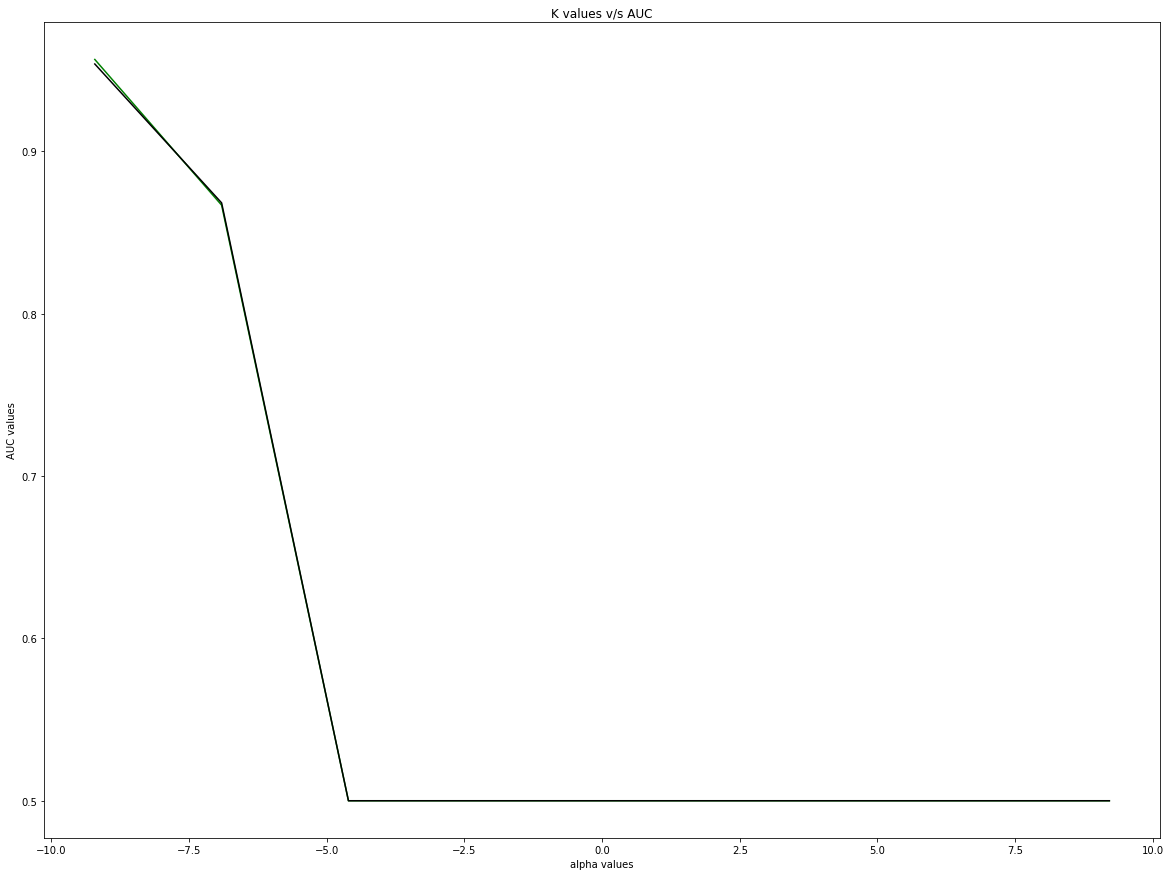

In [77]:

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_tr,color='green')




plt.plot(after_data,auc_cv,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [78]:
best_alpha1=0.0001

In [79]:
svm = linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha= best_alpha1) 
svm_fit = svm.fit(final_counts_x_train,y_tr) 
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(final_counts_x_train, y_tr)
prediction = calib_class.predict_proba(final_counts_x_test)[:,1]

In [80]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9524648631928222


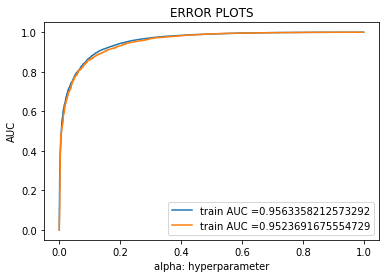

Train confusion matrix
[[ 5811  2597]
 [ 1188 43067]]
Test confusion matrix
[[ 1953   908]
 [  413 14281]]


In [81]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm = linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha=best_alpha1)
svm.fit(final_counts_x_train, y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
calib_class = calib_class.fit(final_counts_x_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, calib_class.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, calib_class.predict(final_counts_x_test))
print(confusion_matrix(y_test, calib_class.predict(final_counts_x_test)))


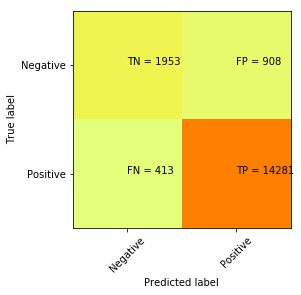

In [82]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


L2 REGULARIZATION

In [83]:
%%time
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_linear =linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha=i)
    svm = svm_linear.fit(final_counts_x_train,y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
    calib_class = calib_class.fit(final_counts_x_train, y_tr)
 
    pred1 = calib_class.predict_proba(final_counts_x_train)[:,1]
    pred2 = calib_class.predict_proba(final_counts_x_crossval)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.9682780848729269
AUC score on crossval data for K 0.0001 is  0.9620432408539354
AUC score on train data for K 0.001 is  0.9518735700600308
AUC score on crossval data for K 0.001 is  0.9489217459792137
AUC score on train data for K 0.01 is  0.9486651591347223
AUC score on crossval data for K 0.01 is  0.9459873233882147
AUC score on train data for K 0.1 is  0.6153047799164968
AUC score on crossval data for K 0.1 is  0.6233149085599915
AUC score on train data for K 1 is  0.5486224121062939
AUC score on crossval data for K 1 is  0.5547016708279768
AUC score on train data for K 10 is  0.5486224121062939
AUC score on crossval data for K 10 is  0.5547016708279768
AUC score on train data for K 100 is  0.5486224121062939
AUC score on crossval data for K 100 is  0.5547016708279768
AUC score on train data for K 1000 is  0.5486224121062939
AUC score on crossval data for K 1000 is  0.5547016708279768
AUC score on train data for K 10000 is  0.54862241210629

Text(0.5,1,'K values v/s AUC')

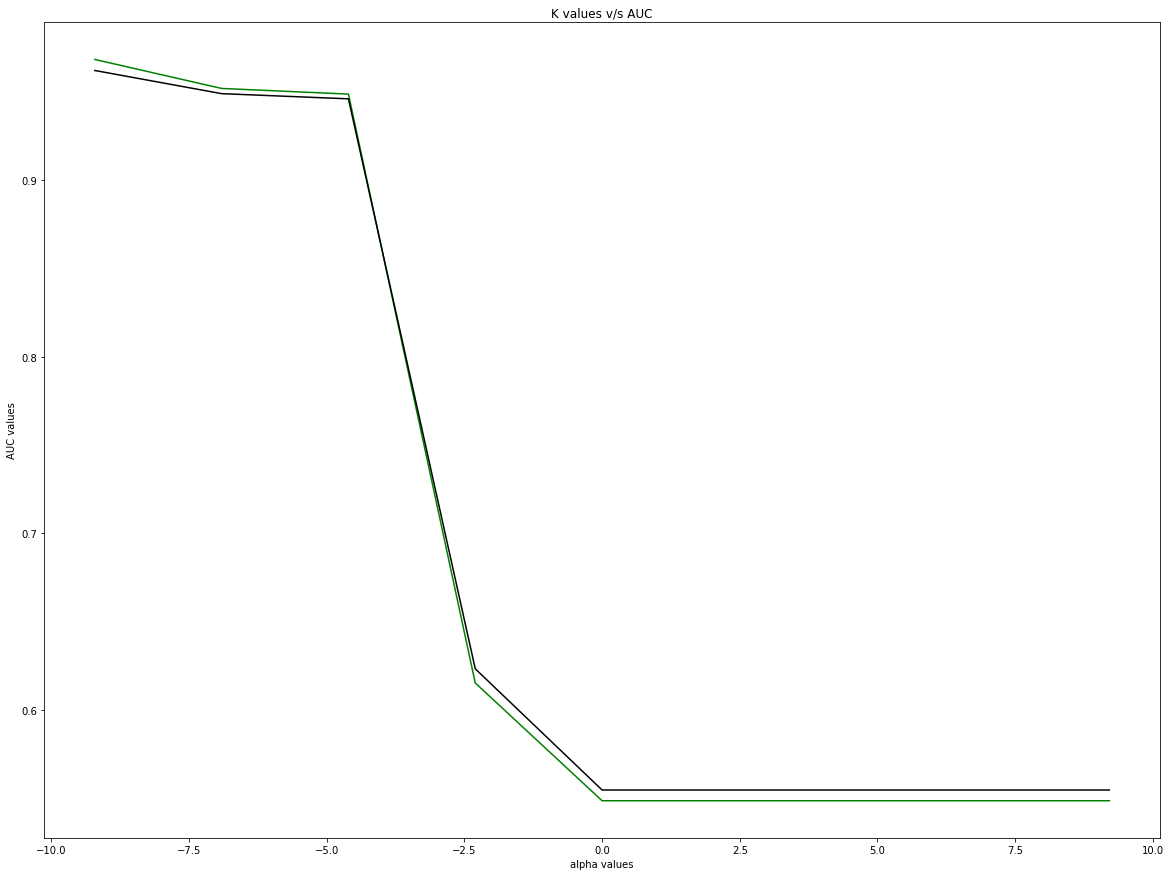

In [84]:

plt.figure(figsize = (20,15))
plt.plot(after_data,auc_tr,color='green')




plt.plot(after_data, auc_cv,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [85]:
best_alpha2=0.0001

In [86]:
svm = linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha = best_alpha2) 
svm_fit = svm.fit(final_counts_x_train,y_tr) 
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(final_counts_x_train, y_tr)
prediction = calib_class.predict_proba(final_counts_x_test)[:,1]

In [87]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9598657539829057


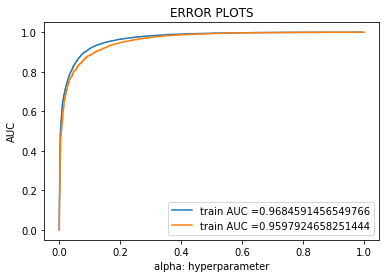

Train confusion matrix
[[ 6306  2102]
 [ 1115 43140]]
Test confusion matrix
[[ 2073   788]
 [  461 14233]]


In [88]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm = linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha=best_alpha2)
svm.fit(final_counts_x_train, y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
calib_class = calib_class.fit(final_counts_x_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, calib_class.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, calib_class.predict(final_counts_x_test))
print(confusion_matrix(y_test, calib_class.predict(final_counts_x_test)))


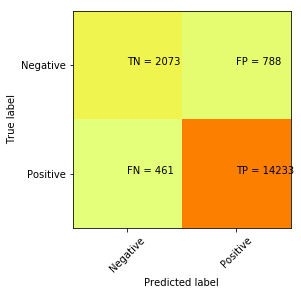

In [89]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


In [90]:
#Reference:https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/4%20Amazon%20Food%20Reviews%20-%20Logistic%20Regression.ipynb
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [91]:
show_most_informative_features(count_vect,svm)

			Negative						Positive
________________________________________________________________________________________________
	-4.0614	disappointed   				3.5238	delicious      
	-3.6704	worst          				3.3394	great          
	-3.6217	terrible       				3.2811	best           
	-3.3593	horrible       				3.1450	excellent      
	-3.1718	awful          				2.5022	perfect        
	-3.1149	disappointing  				2.4290	love           
	-2.6524	stale          				2.4216	yummy          
	-2.6020	poor           				2.4215	wonderful      
	-2.5781	unfortunately  				2.4162	nice           
	-2.4885	yuck           				2.3903	tasty          


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [92]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(x_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


final_tf_idf_tr = tf_idf_vect.transform(x_tr)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
final_tf_idf_test = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_tf_idf_tr))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_tr.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able figure']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (52663, 33871)
the number of unique words including both unigrams and bigrams  33871


In [93]:
from sklearn.preprocessing import normalize
final_tf_idf_tr=normalize(final_tf_idf_tr)
final_tf_idf_cv=normalize(final_tf_idf_cv)
final_tf_idf_test=normalize(final_tf_idf_test)

In [94]:
%%time
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_linear =linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha=i)
    svm = svm_linear.fit(final_tf_idf_tr,y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
    calib_class = calib_class.fit(final_tf_idf_tr, y_tr)
    pred1 = calib_class.predict_proba(final_tf_idf_tr)[:,1]
    pred2 = calib_class.predict_proba(final_tf_idf_cv)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.9616417484582743
AUC score on crossval data for K 0.0001 is  0.9594010996515606
AUC score on train data for K 0.001 is  0.773356642011025
AUC score on crossval data for K 0.001 is  0.7697525277426934
AUC score on train data for K 0.01 is  0.5
AUC score on crossval data for K 0.01 is  0.5
AUC score on train data for K 0.1 is  0.5
AUC score on crossval data for K 0.1 is  0.5
AUC score on train data for K 1 is  0.5
AUC score on crossval data for K 1 is  0.5
AUC score on train data for K 10 is  0.5
AUC score on crossval data for K 10 is  0.5
AUC score on train data for K 100 is  0.5
AUC score on crossval data for K 100 is  0.5
AUC score on train data for K 1000 is  0.5
AUC score on crossval data for K 1000 is  0.5
AUC score on train data for K 10000 is  0.5
AUC score on crossval data for K 10000 is  0.5
Wall time: 3.75 s


Text(0.5,1,'K values v/s AUC')

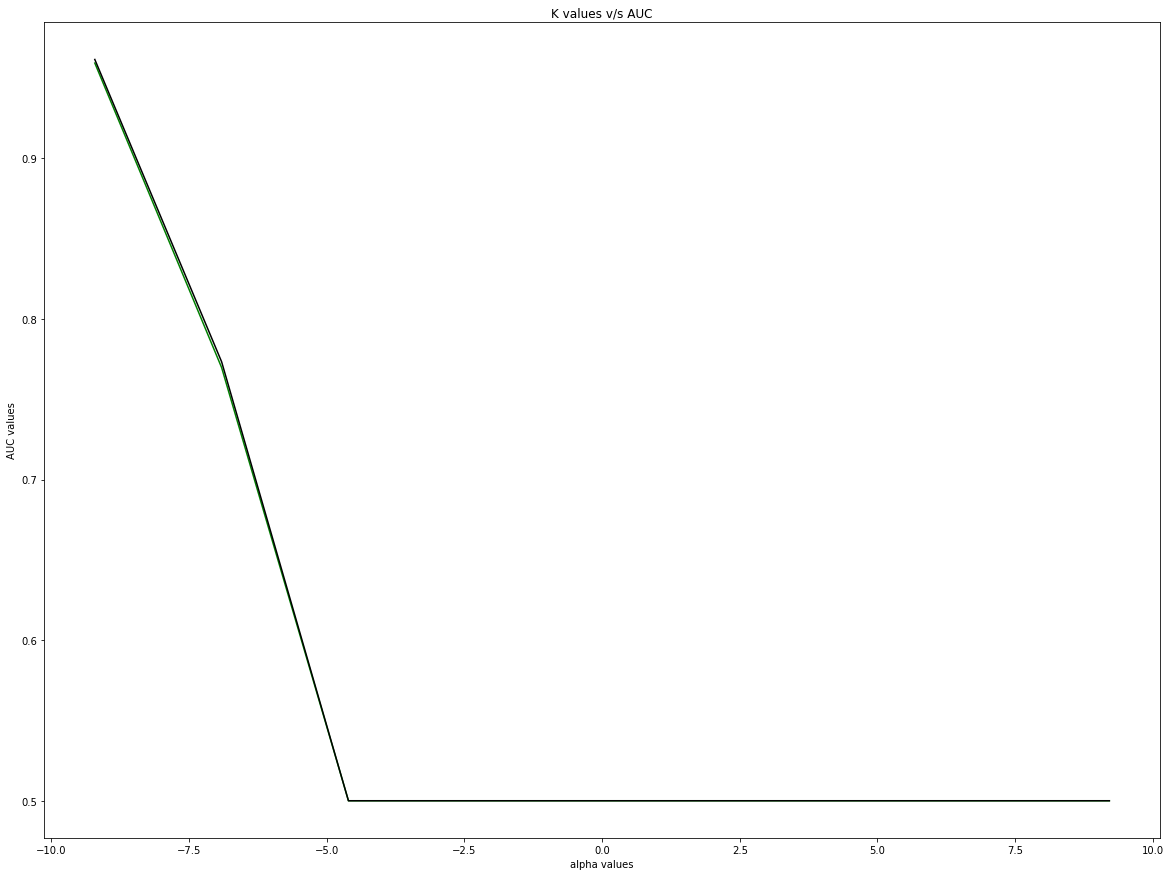

In [95]:

plt.figure(figsize = (20,15))
plt.plot(after_data,auc_cv,color='green')




plt.plot(after_data,auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [96]:
best_alpha3=0.0001

In [97]:
svm = linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha = best_alpha3) 
svm_fit = svm.fit(final_tf_idf_tr,y_tr) 
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(final_tf_idf_tr, y_tr)
prediction = calib_class.predict_proba(final_tf_idf_test)[:,1]

In [98]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9597630649283602


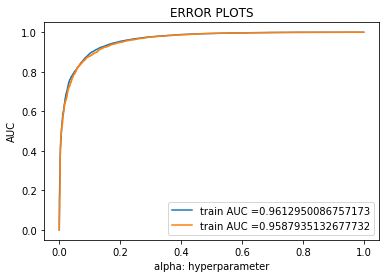

Train confusion matrix
[[ 5900  2508]
 [ 1036 43219]]
Test confusion matrix
[[ 2015   846]
 [  359 14335]]


In [99]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm = linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha=best_alpha3)
svm.fit(final_tf_idf_tr, y_tr)
# rouc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
calib_class = calib_class.fit(final_tf_idf_tr, y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(final_tf_idf_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, calib_class.predict(final_tf_idf_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, calib_class.predict(final_tf_idf_test))
print(confusion_matrix(y_test, calib_class.predict(final_tf_idf_test)))


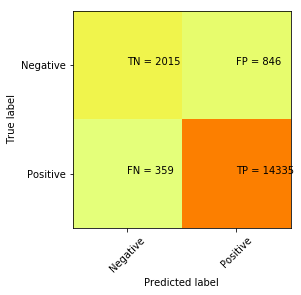

In [100]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


L2 REGULARIZATION

In [101]:
%%time
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_linear =linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha=i)
    svm = svm_linear.fit(final_tf_idf_tr,y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
    calib_class = calib_class.fit(final_tf_idf_tr, y_tr)
    pred1 = calib_class.predict_proba(final_tf_idf_tr)[:,1]
    pred2 = calib_class.predict_proba(final_tf_idf_cv)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.9850216304371312
AUC score on crossval data for K 0.0001 is  0.9736681274404076
AUC score on train data for K 0.001 is  0.9749891694628087
AUC score on crossval data for K 0.001 is  0.9666018736777802
AUC score on train data for K 0.01 is  0.9750567299775619
AUC score on crossval data for K 0.01 is  0.9667240113229665
AUC score on train data for K 0.1 is  0.6510241415092727
AUC score on crossval data for K 0.1 is  0.6630300464235621
AUC score on train data for K 1 is  0.6510023702482832
AUC score on crossval data for K 1 is  0.6630081657739925
AUC score on train data for K 10 is  0.6510023702482832
AUC score on crossval data for K 10 is  0.6630081657739925
AUC score on train data for K 100 is  0.6510023702482832
AUC score on crossval data for K 100 is  0.6630081657739925
AUC score on train data for K 1000 is  0.6510023702482832
AUC score on crossval data for K 1000 is  0.6630081657739925
AUC score on train data for K 10000 is  0.65100237024828

Text(0.5,1,'K values v/s AUC')

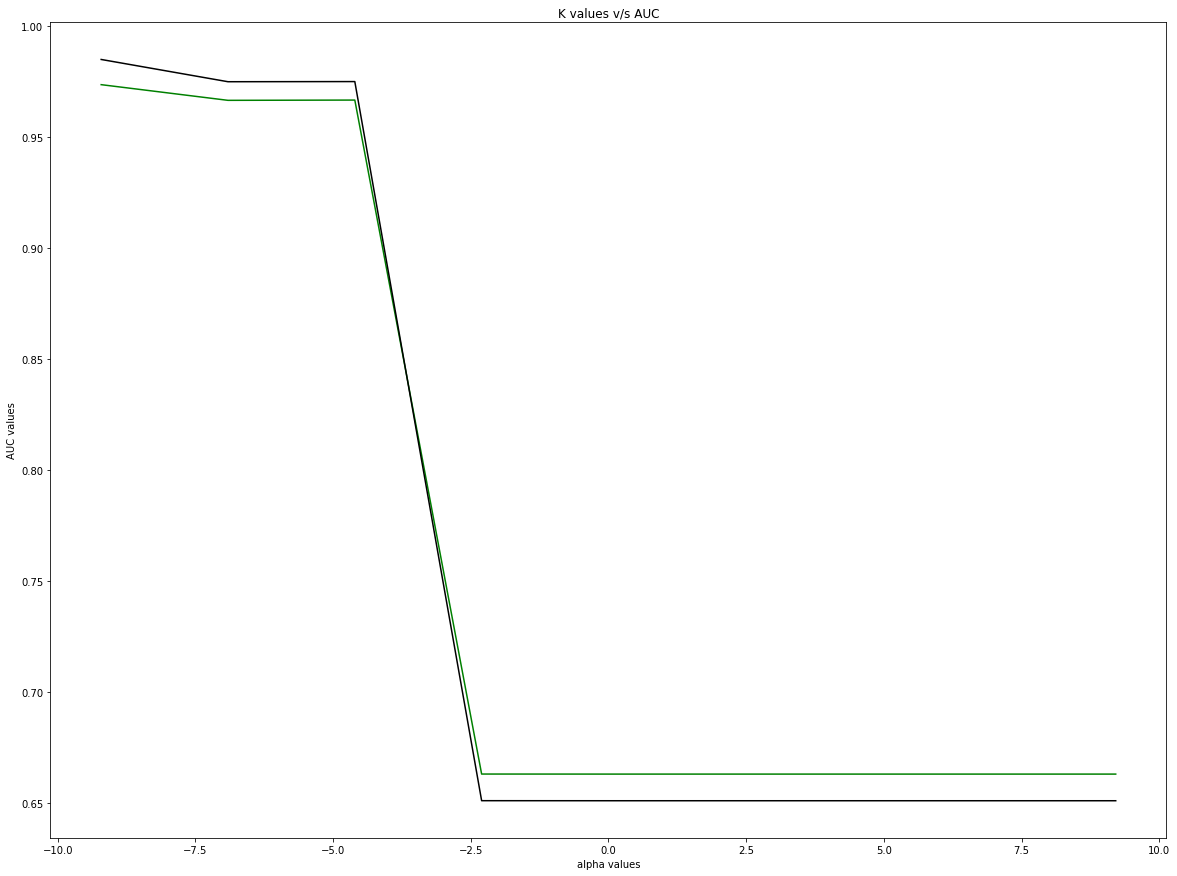

In [102]:

plt.figure(figsize = (20,15))
plt.plot(after_data,auc_cv,color='green')




plt.plot(after_data,auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [103]:
best_alpha4=0.01

In [104]:
svm = linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha = best_alpha4) 
svm_fit = svm.fit(final_tf_idf_tr,y_tr) 
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(final_tf_idf_tr, y_tr)
prediction = calib_class.predict_proba(final_tf_idf_test)[:,1]

In [105]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9660183911648498


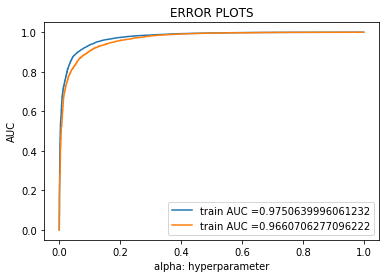

Train confusion matrix
[[ 6506  1902]
 [  957 43298]]
Test confusion matrix
[[ 2125   736]
 [  405 14289]]


In [106]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm = linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha=best_alpha4)
svm.fit(final_tf_idf_tr, y_tr)
# rouc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
calib_class = calib_class.fit(final_tf_idf_tr, y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(final_tf_idf_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, calib_class.predict(final_tf_idf_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, calib_class.predict(final_tf_idf_test))
print(confusion_matrix(y_test, calib_class.predict(final_tf_idf_test)))


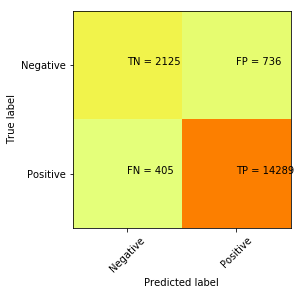

In [107]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [108]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'], random_state = 0, test_size = 0.2, shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

In [109]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]

for sentance in x_tr:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [110]:
import gensim
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
  

In [111]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12584
sample words  ['bought', 'apartment', 'infested', 'fruit', 'fly', 'hour', 'trap', 'attracted', 'many', 'within', 'day', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'sure', 'death', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decal', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumb', 'great', 'received', 'shipment', 'could']


In [112]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|███████████████████████████████████████████████████████████████████████████| 52663/52663 [02:40<00:00, 327.94it/s]


52663
50


In [113]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:55<00:00, 315.36it/s]


17555
50


In [114]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:55<00:00, 316.55it/s]


17555
50


In [115]:
%%time
# Please write all the code with proper documentation
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    svm = linear_model.SGDClassifier(penalty='l1',alpha=i)
    svm.fit(sent_vectors_tr, y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
    calib_class = calib_class.fit(sent_vectors_tr, y_tr)
    
    pred_tr = calib_class.predict_proba(sent_vectors_tr)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = calib_class.predict_proba(sent_vectors_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_tr = [x for x in auc_score_tr]
auc_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.9132842712975645
AUC score on crossval datafor C value 1e-05 is  0.9128281761600919
AUC score on train data for C value 0.0001 is  0.9216618281589287
AUC score on crossval datafor C value 0.0001 is  0.9201148785461963
AUC score on train data for C value 0.001 is  0.927493393374657
AUC score on crossval datafor C value 0.001 is  0.9279585522805052
AUC score on train data for C value 0.01 is  0.9057649134281884
AUC score on crossval datafor C value 0.01 is  0.9040712590586772
AUC score on train data for C value 0.1 is  0.5
AUC score on crossval datafor C value 0.1 is  0.5
AUC score on train data for C value 10 is  0.5
AUC score on crossval datafor C value 10 is  0.5
AUC score on train data for C value 100 is  0.5
AUC score on crossval datafor C value 100 is  0.5
AUC score on train data for C value 1000 is  0.5
AUC score on crossval datafor C value 1000 is  0.5
AUC score on train data for C value 10000 is  0.5
AUC score on crossval datafor C

In [116]:
len(auc_tr)

9

Text(0.5,1,'K values v/s AUC')

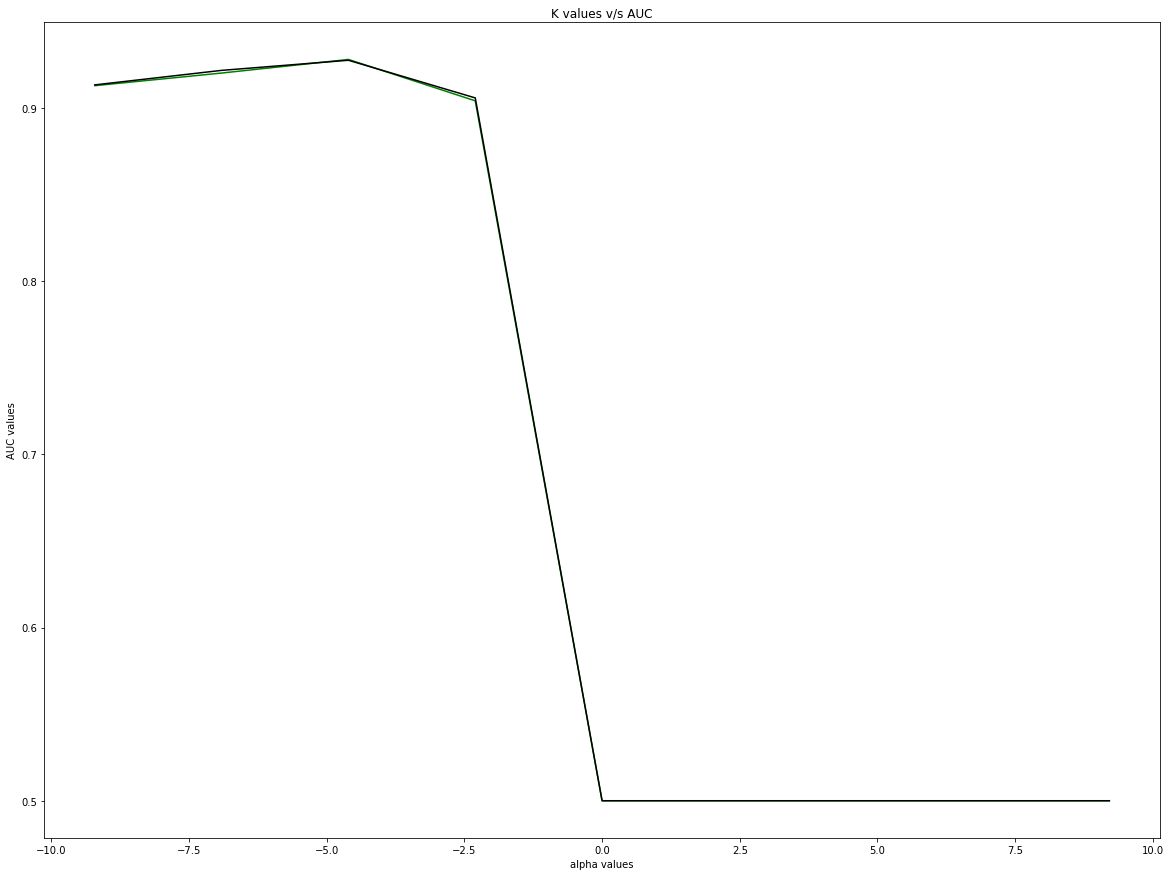

In [117]:

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [118]:
best_alpha5=0.001

In [119]:
svm = linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha=best_alpha5) 
svm_fit = svm.fit(sent_vectors_tr,y_tr) 
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(sent_vectors_tr, y_tr)
prediction = calib_class.predict_proba(sent_vectors_test)[:,1]

In [120]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.931321778233266


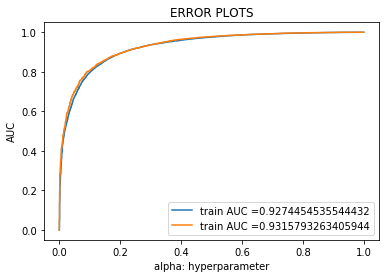

Train confusion matrix
[[ 3912  4113]
 [ 1027 43611]]
Test confusion matrix
[[ 1495  1419]
 [  338 14303]]


In [121]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha=best_alpha5)
neigh.fit( sent_vectors_tr,y_tr)
calib_class = CalibratedClassifierCV(base_estimator = neigh, cv = 'prefit') 
calib_class = calib_class.fit(sent_vectors_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(sent_vectors_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, neigh.predict(sent_vectors_test))
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))


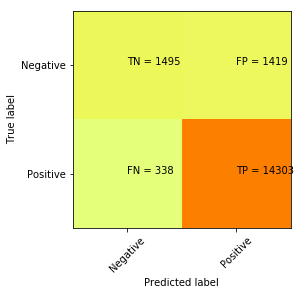

In [122]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()





L2 REGULARIZATION

In [123]:
%%time
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_linear =linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha=i)
    svm = svm_linear.fit(sent_vectors_tr,y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
    calib_class = calib_class.fit(sent_vectors_tr, y_tr)
    pred1 = calib_class.predict_proba(sent_vectors_tr)[:,1]
    pred2 = calib_class.predict_proba(sent_vectors_cv)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.926813221876671
AUC score on crossval data for K 0.0001 is  0.9278995902526974
AUC score on train data for K 0.001 is  0.926813221876671
AUC score on crossval data for K 0.001 is  0.9278995902526974
AUC score on train data for K 0.01 is  0.926813221876671
AUC score on crossval data for K 0.01 is  0.9278995902526974
AUC score on train data for K 0.1 is  0.926813221876671
AUC score on crossval data for K 0.1 is  0.9278995902526974
AUC score on train data for K 1 is  0.926813221876671
AUC score on crossval data for K 1 is  0.9278995902526974
AUC score on train data for K 10 is  0.926813221876671
AUC score on crossval data for K 10 is  0.9278995902526974
AUC score on train data for K 100 is  0.926813221876671
AUC score on crossval data for K 100 is  0.9278995902526974
AUC score on train data for K 1000 is  0.926813221876671
AUC score on crossval data for K 1000 is  0.9278995902526974
AUC score on train data for K 10000 is  0.926813221876671
AUC sc

Text(0.5,1,'K values v/s AUC')

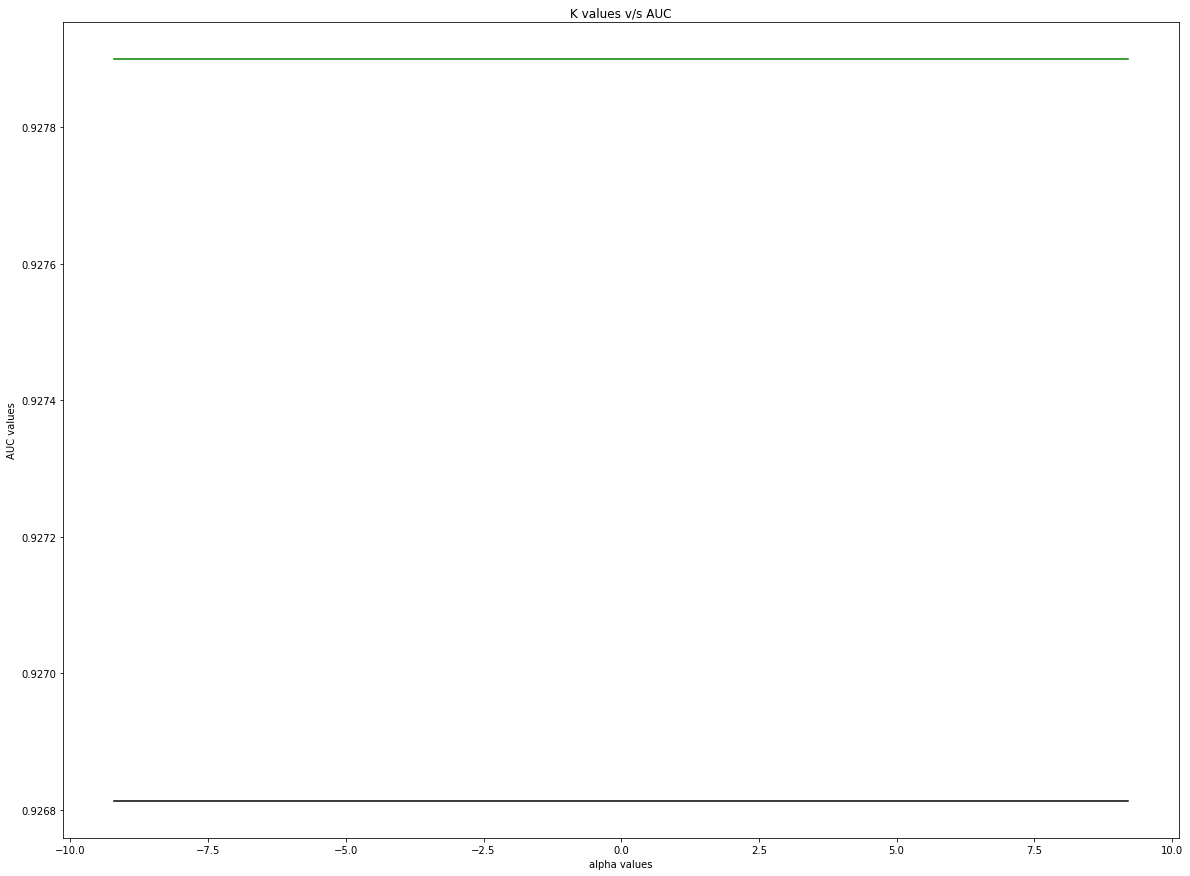

In [124]:

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [125]:
best_alpha6=100

In [126]:
svm = linear_model.SGDClassifier(alpha = best_alpha6,penalty='l2') 
svm_fit = svm.fit(sent_vectors_tr,y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(sent_vectors_tr, y_tr)
prediction = calib_class.predict_proba(sent_vectors_test)[:,1]

In [127]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.6715782303313571


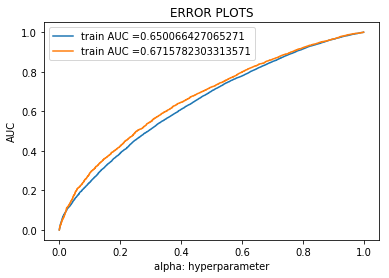

Train confusion matrix
[[ 4122  3903]
 [ 1133 43505]]
Test confusion matrix
[[ 1559  1355]
 [  405 14236]]


In [128]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = linear_model.SGDClassifier(alpha=best_alpha5,penalty='l2')
neigh.fit( sent_vectors_tr,y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(sent_vectors_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(sent_vectors_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, neigh.predict(sent_vectors_test))
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

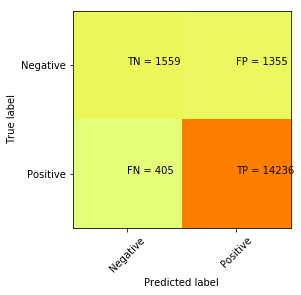

In [129]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [130]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [131]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 52663/52663 [20:56<00:00, 41.90it/s]


In [132]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [07:09<00:00, 40.90it/s]


In [133]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [07:50<00:00, 37.29it/s]


L1 Regularization

In [134]:
%%time
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_linear =linear_model.SGDClassifier(loss='hinge',penalty='l1',alpha=i)
    svm = svm_linear.fit(tfidf_sent_vectors_train,y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
    calib_class = calib_class.fit(tfidf_sent_vectors_train, y_tr)
    pred1 = calib_class.predict_proba(tfidf_sent_vectors_train)[:,1]
    pred2 = calib_class.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.8842264033591652
AUC score on crossval data for K 0.0001 is  0.8812722203983359
AUC score on train data for K 0.001 is  0.9008546704336261
AUC score on crossval data for K 0.001 is  0.8977493702635615
AUC score on train data for K 0.01 is  0.8233301411604798
AUC score on crossval data for K 0.01 is  0.8196954119913507
AUC score on train data for K 0.1 is  0.5
AUC score on crossval data for K 0.1 is  0.5
AUC score on train data for K 1 is  0.5
AUC score on crossval data for K 1 is  0.5
AUC score on train data for K 10 is  0.5
AUC score on crossval data for K 10 is  0.5
AUC score on train data for K 100 is  0.5
AUC score on crossval data for K 100 is  0.5
AUC score on train data for K 1000 is  0.5
AUC score on crossval data for K 1000 is  0.5
AUC score on train data for K 10000 is  0.5
AUC score on crossval data for K 10000 is  0.5
Wall time: 4.93 s


Text(0.5,1,'K values v/s AUC')

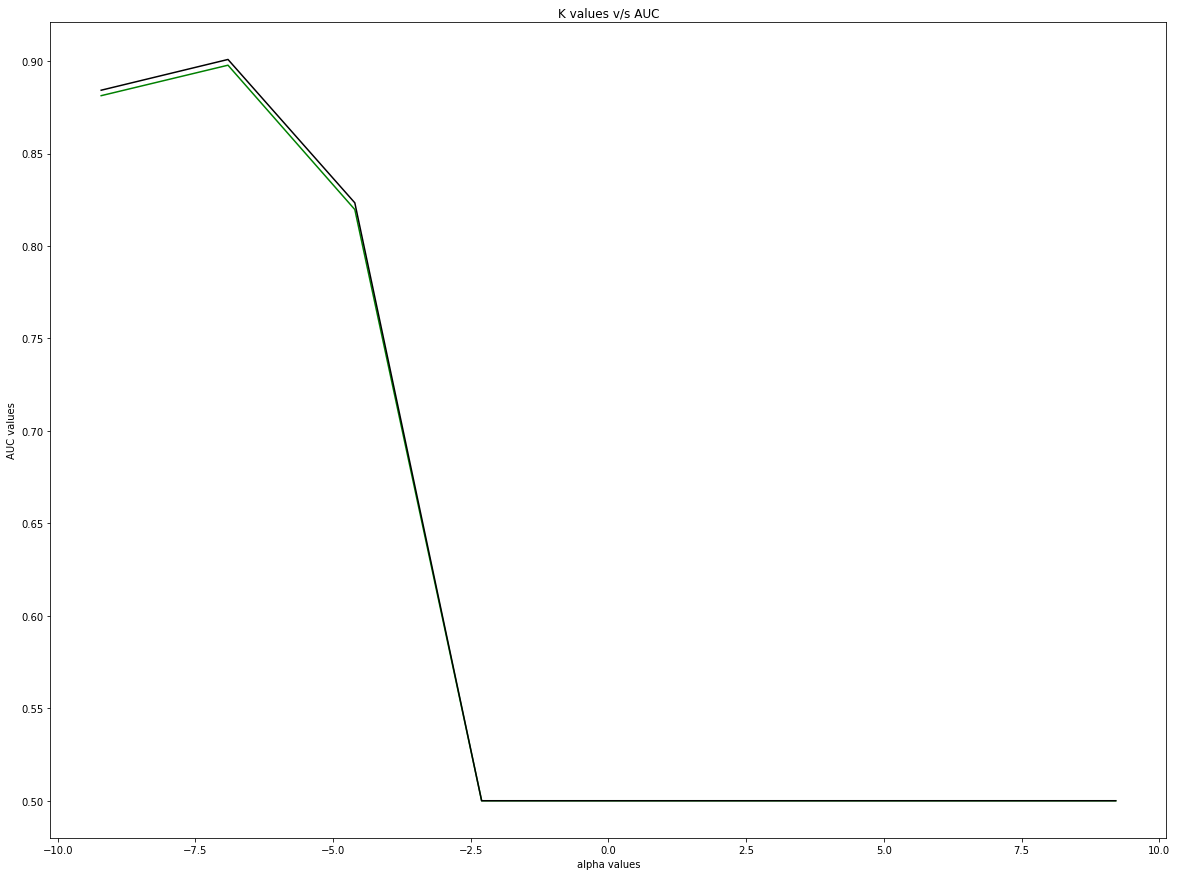

In [135]:

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [136]:
best_alpha7=0.01

In [137]:
svm = linear_model.SGDClassifier(alpha = best_alpha7,penalty='l1') 
svm_fit = svm.fit(tfidf_sent_vectors_train,y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(tfidf_sent_vectors_train, y_tr)
prediction = calib_class.predict_proba(tfidf_sent_vectors_test)[:,1]

In [138]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.8586616161485945


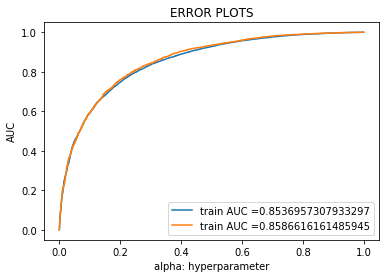

Train confusion matrix
[[    0  8025]
 [    0 44638]]
Test confusion matrix
[[    0  2914]
 [    0 14641]]


In [139]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = linear_model.SGDClassifier(alpha=best_alpha7,penalty='l1')
neigh.fit(tfidf_sent_vectors_train,y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(tfidf_sent_vectors_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test))
print(confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test)))


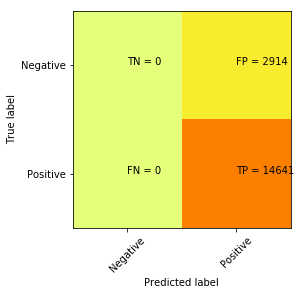

In [140]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

L2 Regularization

In [141]:
%%time
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_linear =linear_model.SGDClassifier(loss='hinge',penalty='l2',alpha=i)
    svm = svm_linear.fit(tfidf_sent_vectors_train,y_tr)
    calib_class = CalibratedClassifierCV(base_estimator = svm, cv = 'prefit') 
    calib_class = calib_class.fit(tfidf_sent_vectors_train, y_tr)
    pred1 = calib_class.predict_proba(tfidf_sent_vectors_train)[:,1]
    pred2 = calib_class.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.8861384995447629
AUC score on crossval data for K 0.0001 is  0.884004817301114
AUC score on train data for K 0.001 is  0.8995759700150704
AUC score on crossval data for K 0.001 is  0.8958872606375494
AUC score on train data for K 0.01 is  0.8992561329987344
AUC score on crossval data for K 0.01 is  0.8965071808465819
AUC score on train data for K 0.1 is  0.8940044573173549
AUC score on crossval data for K 0.1 is  0.8905000794565047
AUC score on train data for K 1 is  0.8952884533650345
AUC score on crossval data for K 1 is  0.8921481931263293
AUC score on train data for K 10 is  0.8603418960892601
AUC score on crossval data for K 10 is  0.8619137755338875
AUC score on train data for K 100 is  0.6401458210242059
AUC score on crossval data for K 100 is  0.6582894684724045
AUC score on train data for K 1000 is  0.640145483242907
AUC score on crossval data for K 1000 is  0.6582893391697121
AUC score on train data for K 10000 is  0.640145483242907


Text(0.5,1,'K values v/s AUC')

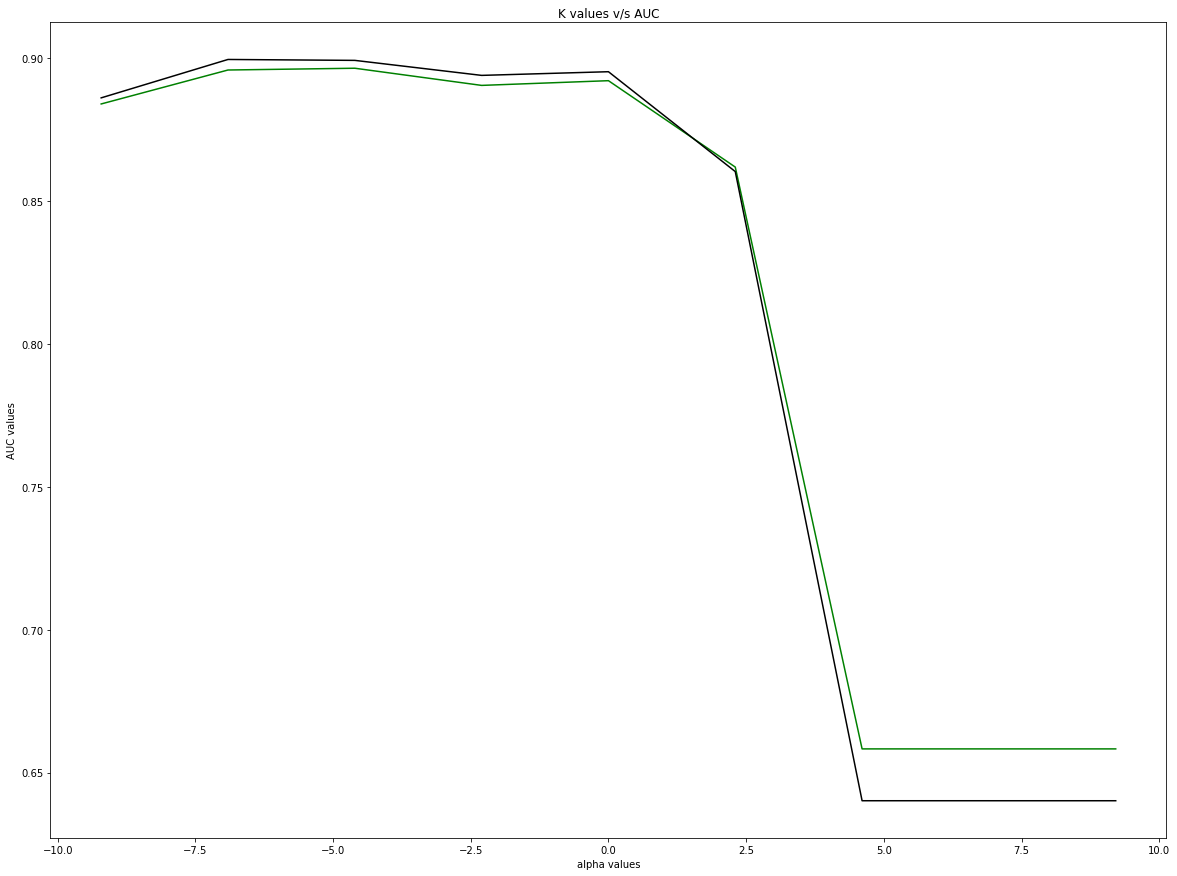

In [142]:

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [143]:
best_alpha8=0.001

In [144]:
svm = linear_model.SGDClassifier(alpha = best_alpha8,penalty='l2') 
svm_fit = svm.fit(tfidf_sent_vectors_train,y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(tfidf_sent_vectors_train, y_tr)
prediction = calib_class.predict_proba(tfidf_sent_vectors_test)[:,1]

In [145]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9029539370944138


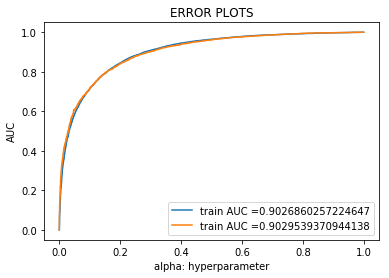

Train confusion matrix
[[ 3261  4764]
 [ 1004 43634]]
Test confusion matrix
[[ 1229  1685]
 [  378 14263]]


In [146]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = linear_model.SGDClassifier(alpha=best_alpha8,penalty='l2')
neigh.fit(tfidf_sent_vectors_train,y_tr)
calib_class = CalibratedClassifierCV(base_estimator = svm_fit, cv = 'prefit') 
calib_class = calib_class.fit(tfidf_sent_vectors_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, calib_class.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, calib_class.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test))
print(confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test)))


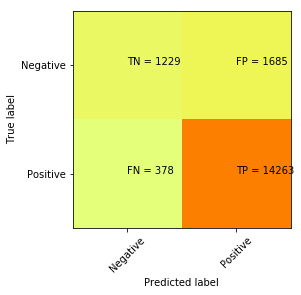

In [147]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [148]:
import math
after_data=[]
for i in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    a=math.log(i)
    after_data.append(a)
    

In [149]:
print(after_data)

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [150]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'][:20000], final['Score'][:20000], random_state = 0, test_size = 0.2, shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# From the split, train is 60%, test is 20% and cv is 20%

In [151]:
print(len(x_tr))

12000


In [152]:
print(len(x_cv))

4000


In [153]:
%%time
#BoW
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
count_vect.fit(x_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_x_train = count_vect.transform(x_tr)     #  y_tr
final_counts_x_crossval = count_vect.transform(x_cv) # y_cv
final_counts_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_x_test))
print("the shape of out text BOW vectorizer ",final_counts_x_test.get_shape())
print("the number of unique words ", final_counts_x_test.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almond', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 500)
the number of unique words  500
Wall time: 1.67 s


In [154]:
%%time
# Please write all the code with proper documentation
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_rbf =SVC(kernel='rbf',C=i, probability=True)
    svm_rbf = svm_rbf.fit(final_counts_x_train,y_tr)
    
    pred1 = svm_rbf.predict_proba(final_counts_x_train)[:,1]
    pred2 = svm_rbf.predict_proba(final_counts_x_crossval)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]

AUC score on train data for K 0.0001 is  0.7674583295809769
AUC score on crossval data for K 0.0001 is  0.7622348789888489
AUC score on train data for K 0.001 is  0.9159279082504668
AUC score on crossval data for K 0.001 is  0.8858371639383452
AUC score on train data for K 0.01 is  0.9399375080450636
AUC score on crossval data for K 0.01 is  0.9017962720339189
AUC score on train data for K 0.1 is  0.9406641178850593
AUC score on crossval data for K 0.1 is  0.9024916957498968
AUC score on train data for K 1 is  0.9407401052512739
AUC score on crossval data for K 1 is  0.9025030799103719
AUC score on train data for K 10 is  0.9561616879060929
AUC score on crossval data for K 10 is  0.9043240506228868
AUC score on train data for K 100 is  0.9835791267211276
AUC score on crossval data for K 100 is  0.9040285574140334
AUC score on train data for K 1000 is  0.998136744373753
AUC score on crossval data for K 1000 is  0.8796377461144128
AUC score on train data for K 10000 is  0.999999724808089

Text(0.5,1,'K values v/s AUC')

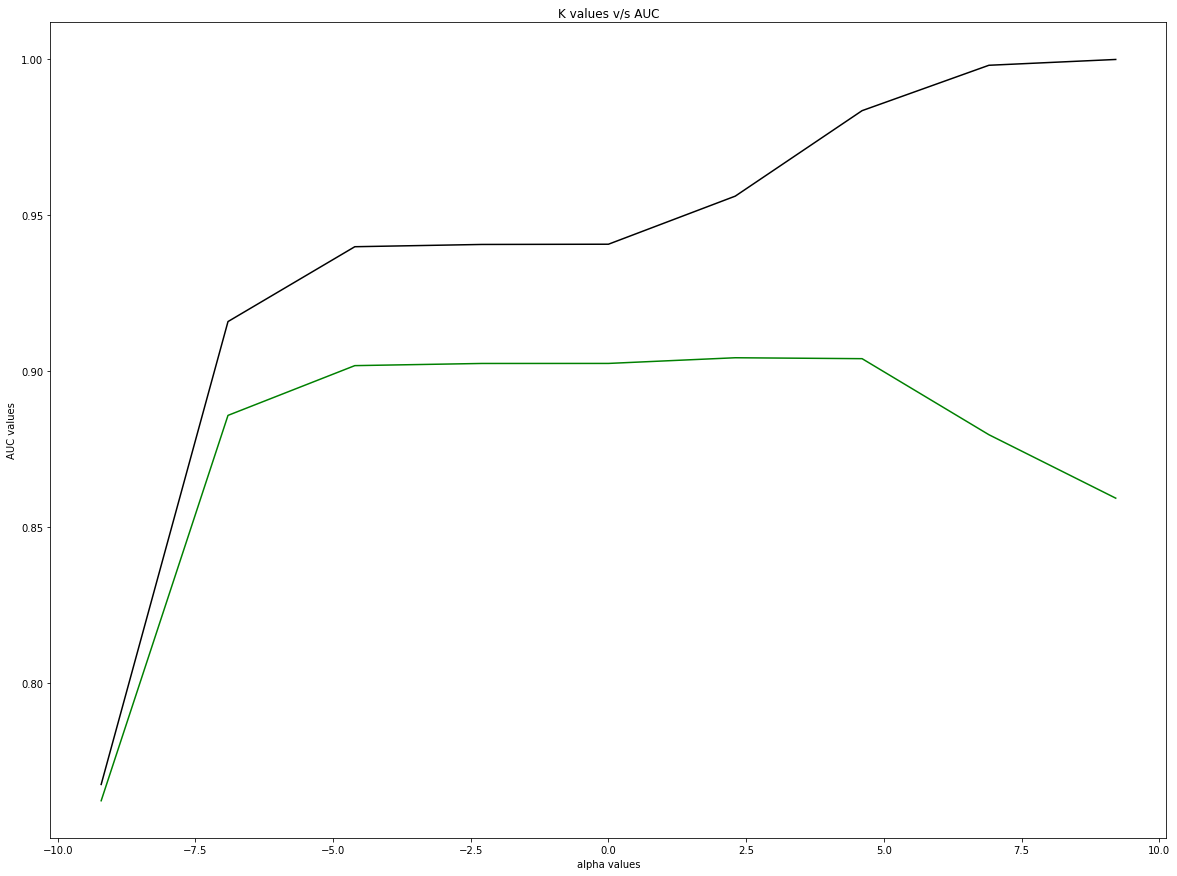

In [155]:

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [156]:
best_alpha9=0.01

In [157]:
svm_rbf = SVC(kernel='rbf',C=best_alpha9,probability=True) 
svm_rbf = svm_rbf.fit(final_counts_x_train,y_tr) 
prediction = svm_rbf.predict_proba(final_counts_x_test)[:,1]

In [158]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9172651022226707


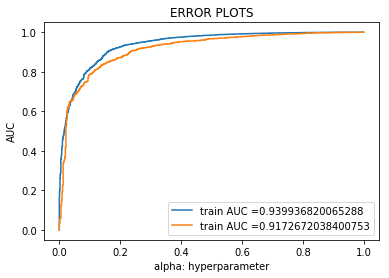

Train confusion matrix
[[    0  1367]
 [    0 10633]]
Test confusion matrix
[[   0  552]
 [   0 3448]]


In [159]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm_rbf =SVC(kernel='rbf',C=best_alpha9,probability=True)
svm_rbf.fit(final_counts_x_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, svm_rbf.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, svm_rbf.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, svm_rbf.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, svm_rbf.predict(final_counts_x_test))
print(confusion_matrix(y_test, svm_rbf.predict(final_counts_x_test)))


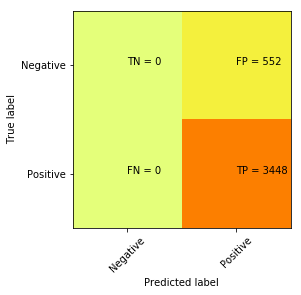

In [160]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [161]:
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect.fit(x_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


final_tf_idf_tr = tf_idf_vect.transform(x_tr)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
final_tf_idf_test = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_tf_idf_tr))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_tr.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almond', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (12000, 500)
the number of unique words including both unigrams and bigrams  500


In [162]:
%%time
# Please write all the code with proper documentation
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_rbf =SVC(kernel='rbf',C=i,probability=True)
    svm_rbf = svm_rbf.fit(final_tf_idf_tr,y_tr)
    
    pred1 = svm_rbf.predict_proba(final_tf_idf_tr)[:,1]
    pred2 = svm_rbf.predict_proba(final_tf_idf_cv)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.8643445262368312
AUC score on crossval data for K 0.0001 is  0.8625075543804023
AUC score on train data for K 0.001 is  0.8643004611322042
AUC score on crossval data for K 0.001 is  0.8622679920469266
AUC score on train data for K 0.01 is  0.8901755524873187
AUC score on crossval data for K 0.01 is  0.8838652293586611
AUC score on train data for K 0.1 is  0.9332224126473798
AUC score on crossval data for K 0.1 is  0.9059208028703923
AUC score on train data for K 1 is  0.935734123611115
AUC score on crossval data for K 1 is  0.9075066659209217
AUC score on train data for K 10 is  0.9358995483481571
AUC score on crossval data for K 10 is  0.9082604953297719
AUC score on train data for K 100 is  0.9374315073134658
AUC score on crossval data for K 100 is  0.9078927374500767
AUC score on train data for K 1000 is  0.9446862196481383
AUC score on crossval data for K 1000 is  0.9067189315123956
AUC score on train data for K 10000 is  0.950832286973426

Text(0.5,1,'K values v/s AUC')

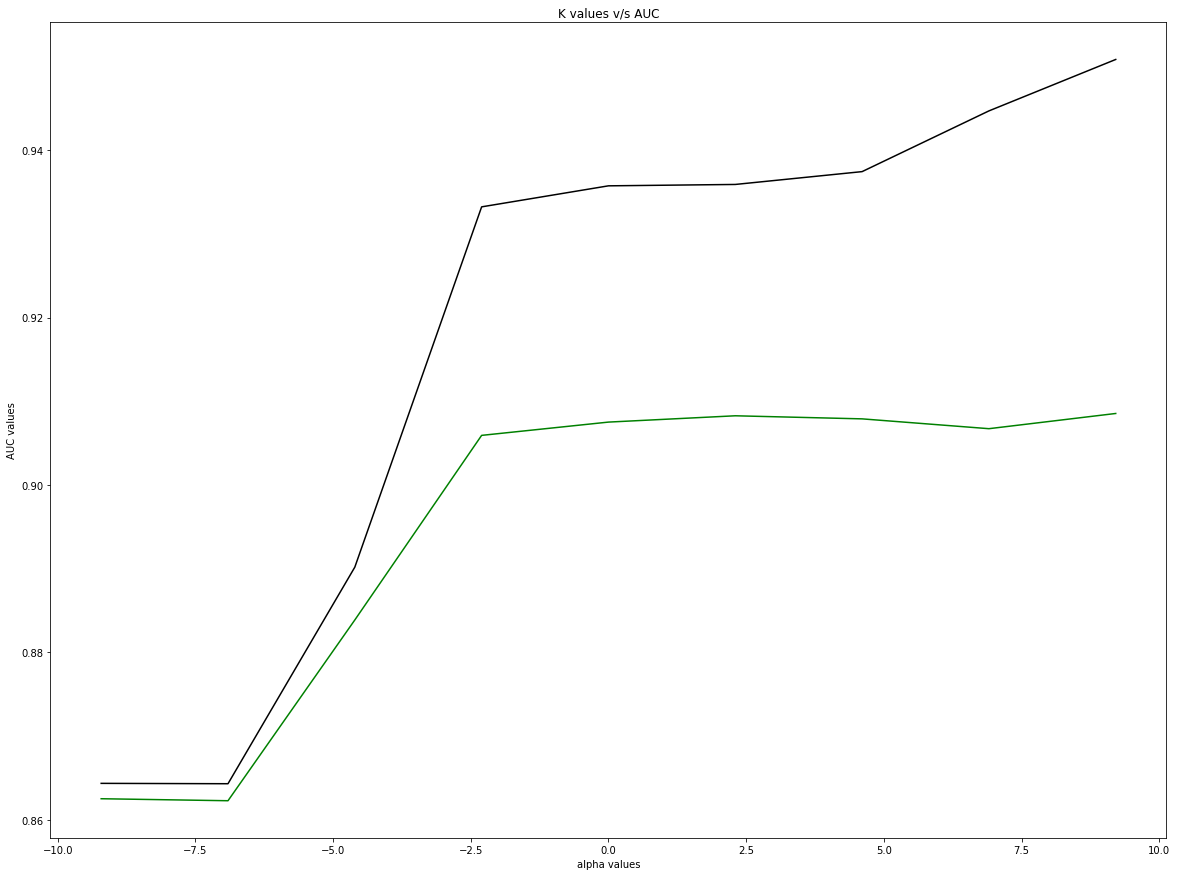

In [163]:

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [164]:
best_alpha10=1

In [165]:
svm_rbf = SVC(kernel='rbf',C=best_alpha10,probability=True)
svm_rbf = svm_rbf.fit(final_tf_idf_tr,y_tr) 
prediction =svm_rbf.predict_proba(final_tf_idf_test)[:,1]

In [166]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9248553561821178


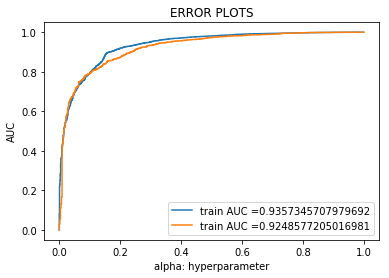

Train confusion matrix
[[    0  1367]
 [    0 10633]]
Test confusion matrix
[[   0  552]
 [   0 3448]]


In [167]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm_rbf = SVC(kernel='rbf',C=best_alpha10,probability=True)
svm_rbf.fit(final_tf_idf_tr, y_tr)
# rouc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, svm_rbf.predict_proba(final_tf_idf_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,svm_rbf.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, svm_rbf.predict(final_tf_idf_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, svm_rbf.predict(final_tf_idf_test))
print(confusion_matrix(y_test, svm_rbf.predict(final_tf_idf_test)))


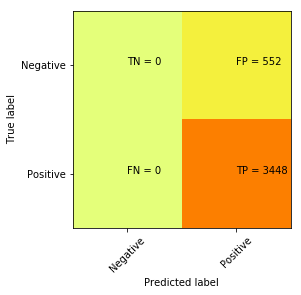

In [168]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [169]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'][:20000], final['Score'][:20000], random_state = 0, test_size = 0.2, shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

In [170]:
# Train your own Word2Vec model using your own text corpus

list_of_sentance_train=[]

for sentance in x_tr:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [171]:
import gensim
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
  

In [172]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6041
sample words  ['bought', 'infested', 'fruit', 'fly', 'hour', 'trap', 'attracted', 'many', 'within', 'day', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'sure', 'death', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumb', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'love']


In [173]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:24<00:00, 498.59it/s]


12000
50


In [174]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 468.13it/s]


4000
50


In [175]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 464.44it/s]


4000
50


In [176]:
%%time
# Please write all the code with proper documentation
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    svm_rbf = SVC(kernel='rbf',C=i,probability=True)
    svm_rbf.fit(sent_vectors_tr, y_tr)
    
    pred_tr = svm_rbf.predict_proba(sent_vectors_tr)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = svm_rbf.predict_proba(sent_vectors_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_tr = [x for x in auc_score_tr]
auc_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.8311130391362112
AUC score on crossval datafor C value 1e-05 is  0.8238419957720218
AUC score on train data for C value 0.0001 is  0.6968141238945627
AUC score on crossval datafor C value 0.0001 is  0.6744964117621146
AUC score on train data for C value 0.001 is  0.8741542578621124
AUC score on crossval datafor C value 0.001 is  0.8593417678413305
AUC score on train data for C value 0.01 is  0.8885073047284644
AUC score on crossval datafor C value 0.01 is  0.8678026738918139
AUC score on train data for C value 0.1 is  0.8984381551932394
AUC score on crossval datafor C value 0.1 is  0.8777682689790042
AUC score on train data for C value 10 is  0.8993119583062241
AUC score on crossval datafor C value 10 is  0.8788047225457358
AUC score on train data for C value 100 is  0.9088115142496779
AUC score on crossval datafor C value 100 is  0.8799965946511275
AUC score on train data for C value 1000 is  0.9230693447150873
AUC score on crossval data

Text(0.5,1,'K values v/s AUC')

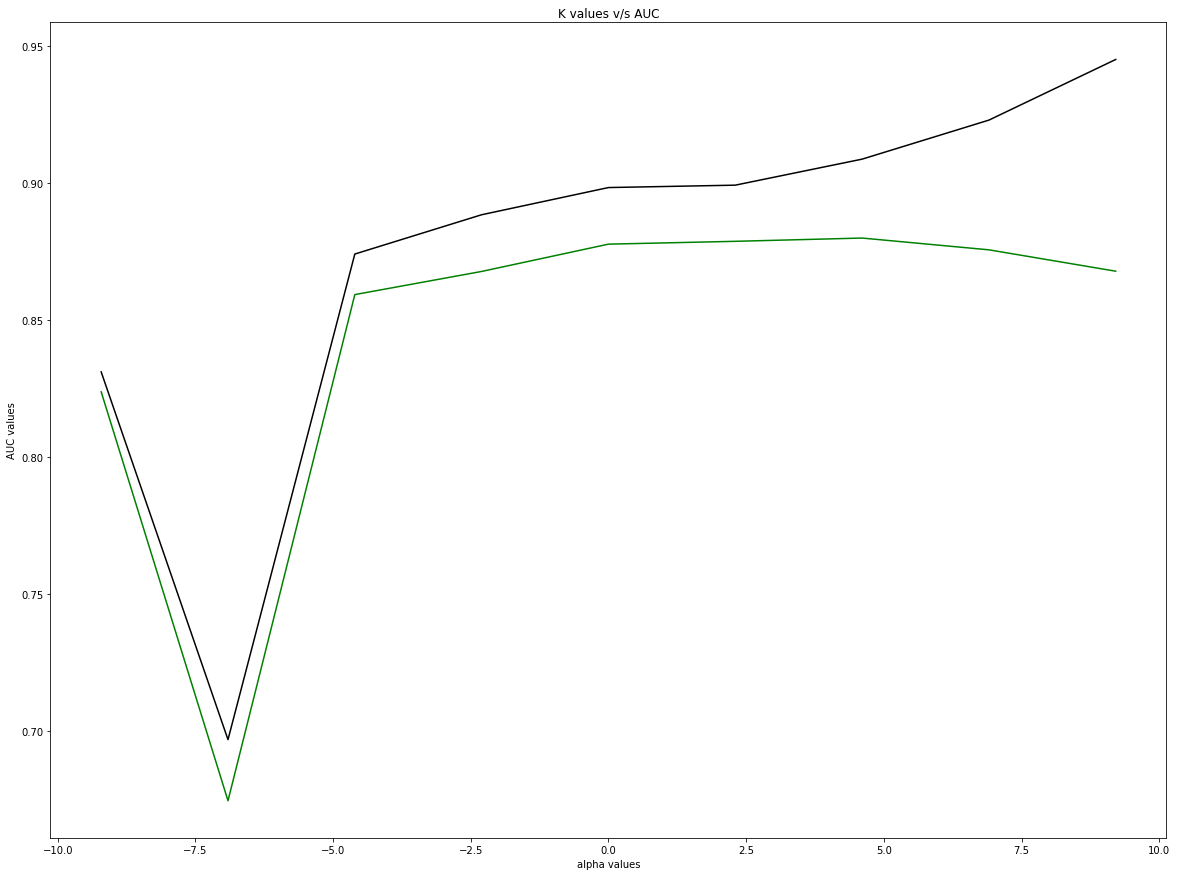

In [177]:
# Please write all the code with proper documentation

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [178]:
best_alpha11=1000

In [179]:
svm_rbf = SVC(kernel='rbf',C=best_alpha11,probability=True) 
svm_rbf.fit(sent_vectors_tr,y_tr) 
prediction = svm_rbf.predict_proba(sent_vectors_test)[:,1]

In [180]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.8991297202326911


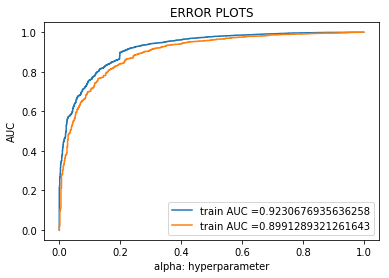

Train confusion matrix
[[  456   911]
 [  108 10525]]
Test confusion matrix
[[ 159  393]
 [  46 3402]]


In [181]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm_rbf = SVC(kernel='rbf',C=best_alpha11,probability=True)
svm_rbf.fit( sent_vectors_tr,y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, svm_rbf.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, svm_rbf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, svm_rbf.predict(sent_vectors_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, svm_rbf.predict(sent_vectors_test))
print(confusion_matrix(y_test, svm_rbf.predict(sent_vectors_test)))


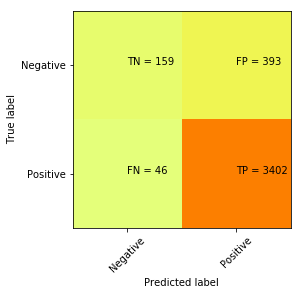

In [182]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [183]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [184]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 12000/12000 [03:06<00:00, 64.27it/s]


In [185]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:13<00:00, 54.09it/s]


In [186]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:02<00:00, 64.08it/s]


In [187]:
%%time
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv =[]
alpha= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in alpha:
    svm_rbf = SVC(kernel='rbf',C=i,probability=True)
    svm_rbf = svm_rbf.fit(tfidf_sent_vectors_train,y_tr)
    
    pred1 = svm_rbf.predict_proba(tfidf_sent_vectors_train)[:,1]
    pred2 = svm_rbf.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred1)
    print("AUC score on train data for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    auc_cv = roc_auc_score(y_cv, pred2)
    print("AUC score on crossval data for K", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)
    
    
    
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
auc_cv = [x for x in auc_score_cv]



AUC score on train data for K 0.0001 is  0.769286291844736
AUC score on crossval data for K 0.0001 is  0.7579970015111235
AUC score on train data for K 0.001 is  0.8063079627260814
AUC score on crossval data for K 0.001 is  0.7913902089290424
AUC score on train data for K 0.01 is  0.8219784220647222
AUC score on crossval data for K 0.01 is  0.7960596945778233
AUC score on train data for K 0.1 is  0.8771874574957496
AUC score on crossval data for K 0.1 is  0.8367456941887821
AUC score on train data for K 1 is  0.8905690769189596
AUC score on crossval data for K 1 is  0.8467142590569658
AUC score on train data for K 10 is  0.8924766728417438
AUC score on crossval data for K 10 is  0.8482422113781218
AUC score on train data for K 100 is  0.8948102314425883
AUC score on crossval data for K 100 is  0.8487304928698034
AUC score on train data for K 1000 is  0.9134772898908046
AUC score on crossval data for K 1000 is  0.8520143282033666
AUC score on train data for K 10000 is  0.940349332738735

Text(0.5,1,'K values v/s AUC')

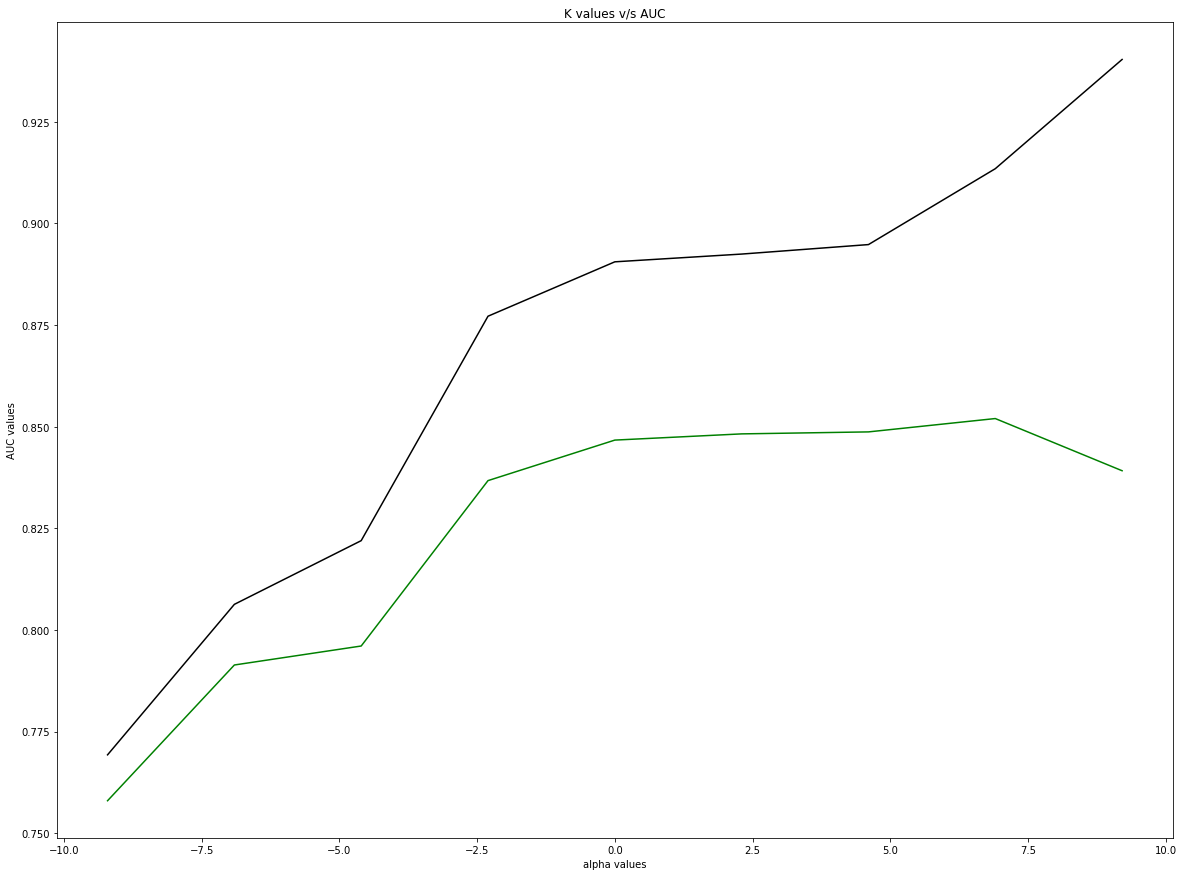

In [188]:
# Please write all the code with proper documentation

plt.figure(figsize = (20,15))
plt.plot(after_data, auc_cv,color='green')




plt.plot(after_data, auc_tr,  color = 'black')


plt.xlabel("alpha values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
#plt.xticks(np.arange(0,50,1))
#plt.yticks(np.arange(0.58,1,0.02))

In [189]:
best_alpha12=1000

In [190]:
svm_rbf = SVC(kernel='rbf',C=best_alpha12,probability=True) 
svm_rbf = svm_rbf.fit(tfidf_sent_vectors_train,y_tr)
prediction = svm_rbf.predict_proba(tfidf_sent_vectors_test)[:,1]

In [191]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.8812659722922762


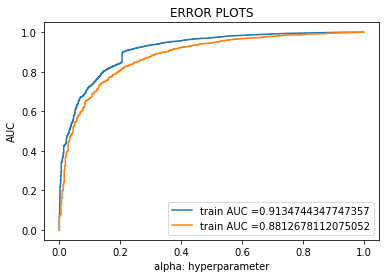

Train confusion matrix
[[  342  1025]
 [   61 10572]]
Test confusion matrix
[[  77  475]
 [  26 3422]]


In [192]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


svm_rbf = SVC(kernel='rbf',C=best_alpha12,probability=True) 
svm_rbf.fit(tfidf_sent_vectors_train,y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, svm_rbf.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, svm_rbf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, svm_rbf.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test, svm_rbf.predict(tfidf_sent_vectors_test))
print(confusion_matrix(y_test, svm_rbf.predict(tfidf_sent_vectors_test)))


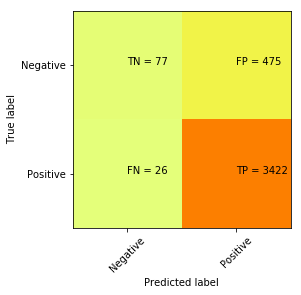

In [193]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# [6] Conclusions

In [194]:
# Please compare all your models using Prettytable library

In [196]:
# Please compare all your models using Prettytable library
# reference from "http://zetcode.com/python/prettytable/"
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["Vectorizer", "regularizer", "Hyper parameter", "AUC" ]
t.add_row(["BOW", "l1",0.001,0.9524])
t.add_row(["BOW", "l2",0.001,0.9598])
t.add_row(["TFIDF", "l1", 0.0001,0.9597])
t.add_row(["TFIDF", "l2", 0.01,0.9660])
t.add_row(["Avg W2V", "l1",0.001,0.9313])
t.add_row(["Avg W2V", "l2", 100,0.6715])
t.add_row(["TFIDF W2V", "l1", 0.01,0.8586])
t.add_row(["TFIDF W2V", "l2", 0.001,0.9029])
print(t)

+------------+-------------+-----------------+--------+
| Vectorizer | regularizer | Hyper parameter |  AUC   |
+------------+-------------+-----------------+--------+
|    BOW     |      l1     |      0.001      | 0.9524 |
|    BOW     |      l2     |      0.001      | 0.9598 |
|   TFIDF    |      l1     |      0.0001     | 0.9597 |
|   TFIDF    |      l2     |       0.01      | 0.966  |
|  Avg W2V   |      l1     |      0.001      | 0.9313 |
|  Avg W2V   |      l2     |       100       | 0.6715 |
| TFIDF W2V  |      l1     |       0.01      | 0.8586 |
| TFIDF W2V  |      l2     |      0.001      | 0.9029 |
+------------+-------------+-----------------+--------+


In [197]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["Vectorizer", "Hyper parameter", "AUC" ]
t.add_row(["BOW",0.01,0.9172])
t.add_row(["TFIDF",1,0.9248])
t.add_row(["Avg W2V", 1000,0.8991])
t.add_row(["TFIDF W2V", 1000,0.8812])
print(t)

+------------+-----------------+--------+
| Vectorizer | Hyper parameter |  AUC   |
+------------+-----------------+--------+
|    BOW     |       0.01      | 0.9172 |
|   TFIDF    |        1        | 0.9248 |
|  Avg W2V   |       1000      | 0.8991 |
| TFIDF W2V  |       1000      | 0.8812 |
+------------+-----------------+--------+


Conclusion:Doing lemmatization and adding summary review and length of summary review has increased the performance of all the models